# Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [112]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve,ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, log_loss
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize
from sklearn.cluster import KMeans
from sklearn import svm

In [113]:
d2=pd.read_csv("Data_set_200_280.csv")

In [114]:
d2

Estado     Sumatoria       Mediana  Varianza
0     Healthy  5.556148e-07  4.686493e-10  0.000008
1     Healthy  6.529095e-07  2.819616e-10  0.000009
2     Healthy  6.096350e-07  2.985569e-10  0.000009
3     Healthy  5.567451e-07  2.556868e-10  0.000008
4     Healthy  5.016411e-07  3.071286e-10  0.000007
...       ...           ...           ...       ...
4914  Wheezes  1.017147e-05  1.164674e-08  0.000136
4915  Wheezes  9.649835e-06  8.796041e-09  0.000129
4916  Wheezes  1.124116e-06  7.448796e-10  0.000015
4917  Wheezes  9.903341e-07  4.516410e-10  0.000013
4918  Wheezes  1.258693e-06  5.698837e-10  0.000015

[4919 rows x 4 columns]

Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [115]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


En este caso Sano:1 crepitante:0 y silibante:2

## Normalización

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna, para ello cada vez que tengamos un Xtv entrenaremos un modelo con estos datos y Xts,Xtv se transformaran bajo dicho modelo se normalizaran los datos usando la función StandardScaler

Ahora revisemos la correlación con nuestro target de predicción que seria el estado

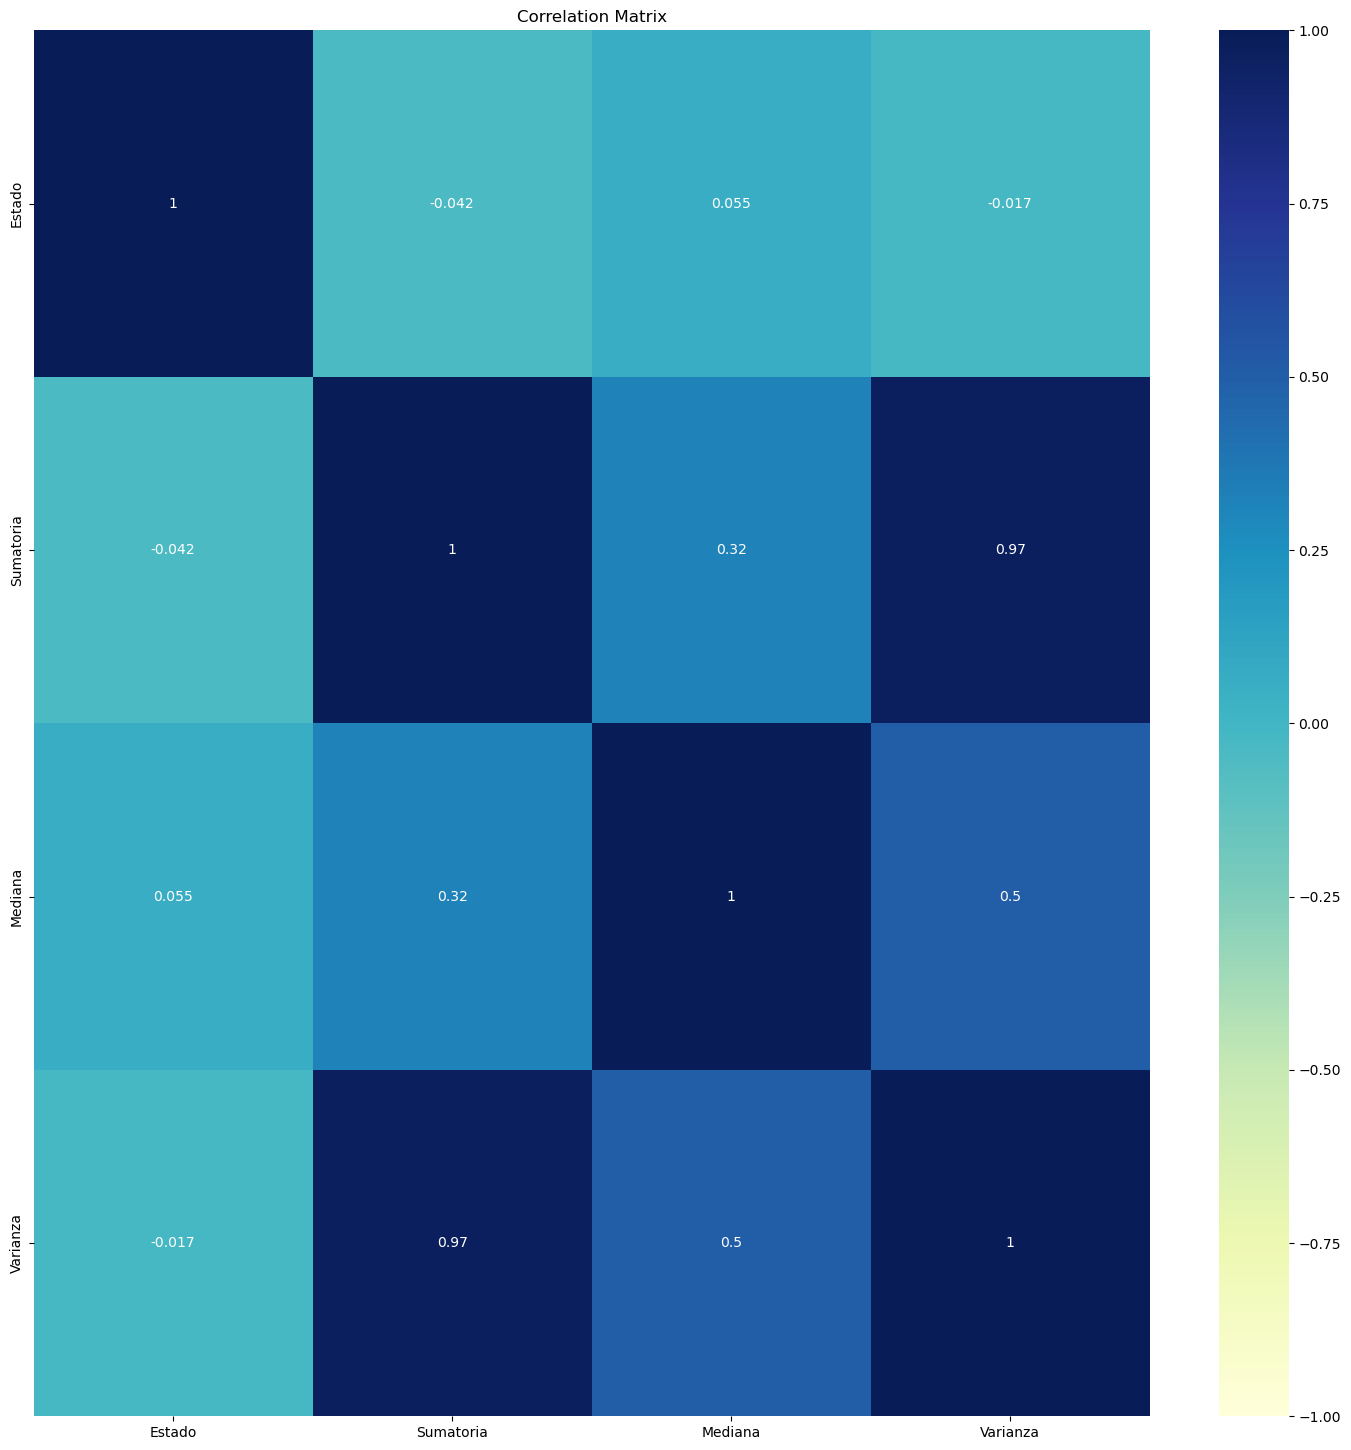

In [116]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [117]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

Estado
Estado     1.000000
Mediana    0.054825
Varianza  -0.016609
Sumatoria -0.042180

En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

In [118]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y,train_sizes= [0.3, 0.5,0.7,0.9],
                 scoring ='neg_log_loss', cv = ShuffleSplit(n_splits=10, test_size=val_size))
    
    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Log_Loss"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

## Funciones de perdida para optimización

- En este caso en vez de usar F1 se usa el coste de log_loss o el coste de la entropía cruzada del sistema que seria la función negativa de esta, debido a que es mejor métrica para los sistemas binarios como son el caso de los primeros ejemplos

Adicionalmente vamos a ver las curvas de aprendizaje para evitar el sobre entrenamiento con los datos dados

# 1. Ciclos normales y ciclos crepitantes

## 1.1 Funciones

In [119]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [120]:
def metrics(a,Xtv,ytv,Xts,yts,target_names):
    def class_plot(report,class_labels):
        class_labels.remove('accuracy')
        metrics = np.zeros((len(class_labels), 3))
        for idx, label in enumerate(class_labels):
            metrics[idx, 0] = report[label]['precision']
            metrics[idx, 1] = report[label]['recall']
            metrics[idx, 2] = report[label]['f1-score']
        fig, ax = plt.subplots()
        heatmap = sns.heatmap(metrics, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
        ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
        ax.set_yticklabels(class_labels, rotation='horizontal')
        cbar = ax.collections[0].colorbar
        cbar.set_label('Metric Value')
        ax.set_title('Heat Map Classification Report')
        plt.show()
    a.fit(Xtv,ytv)
    predict_train = a.predict(Xtv)
    predict_test = a.predict(Xts)
    print("Train ",a.activation)
    print("------------")

    report = classification_report(ytv,predict_train, output_dict=True)
    class_labels = list(report.keys())
    class_plot(report,class_labels)

    mc_train = confusion_matrix(ytv,predict_train)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train '+a.activation,normalize=True)
    print("------------")
    print("Test ",a.activation)
    report = classification_report(yts,predict_test, output_dict=True)
    class_labels = list(report.keys())
    class_plot(report,class_labels)

    mc_train = confusion_matrix(yts,predict_test)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test '+a.activation,normalize=True)

In [121]:
def tuple_generator1(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [122]:
def tuple_generator(start, end):
    return list(itertools.product(range(start, end+ 1), repeat=3))

In [123]:
def me_da_pereza(i,Xtv,ytv,Xts,yts,target_names):
    for a in i:
        metrics(a,Xtv,ytv,Xts,yts,target_names)

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario, esto cambiara la forma del sigmoide, en el proceso se ira permutando los valores hasta encontrar un modelo más adecuado para la predicción 

## 1.2 Resultados

### 1.2.1 Lo que si se pidió

In [178]:
d=d2[d2["Estado"]==1].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d=pd.concat([d2[d2["Estado"]==0],d[:int(len(d2[d2["Estado"]==0]))]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)

(3262, 3) (3262,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2283, 3) (979, 3)


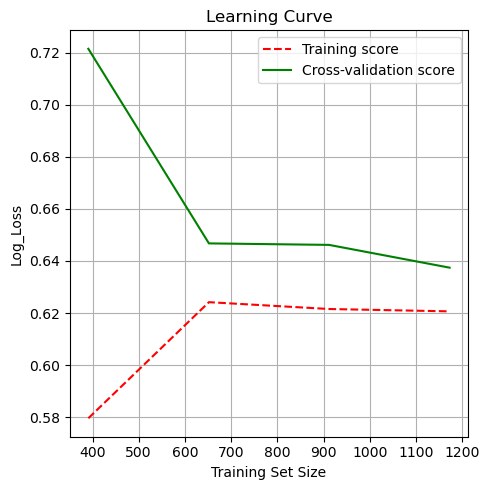

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [179]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------


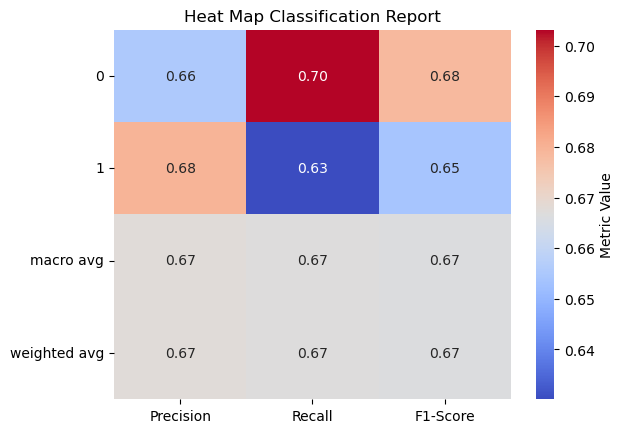

Normalized confusion matrix
------------
Test  relu


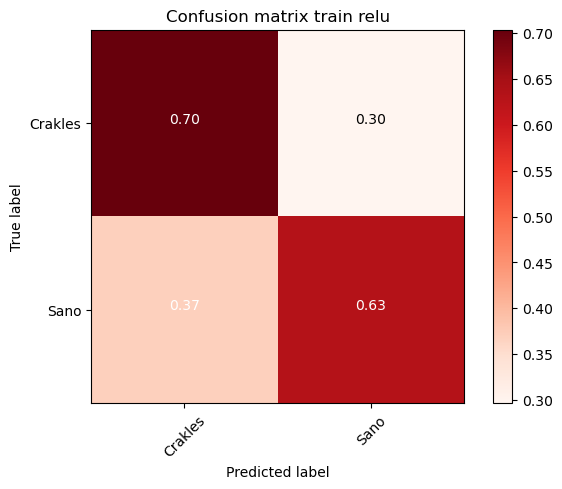

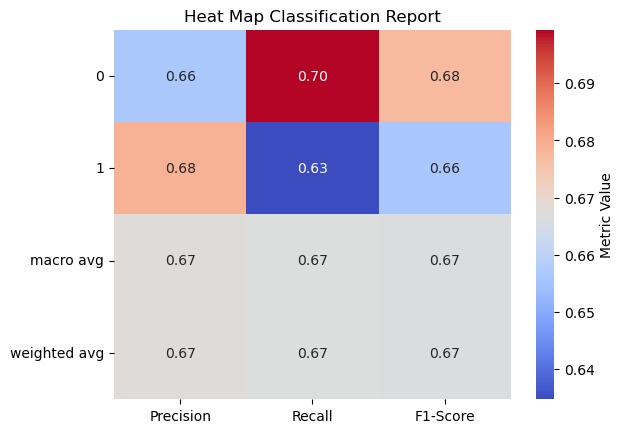

Normalized confusion matrix
Train  identity
------------


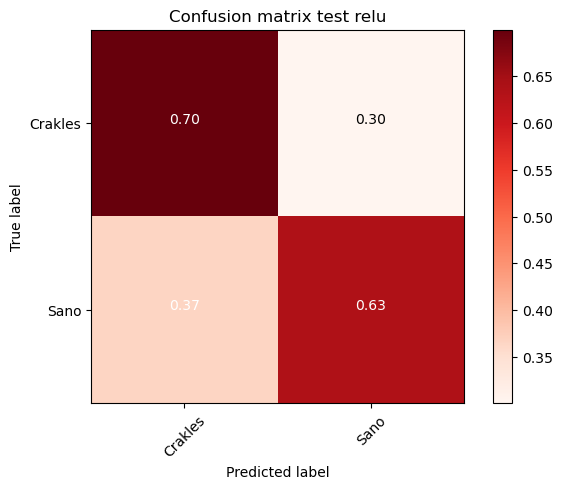

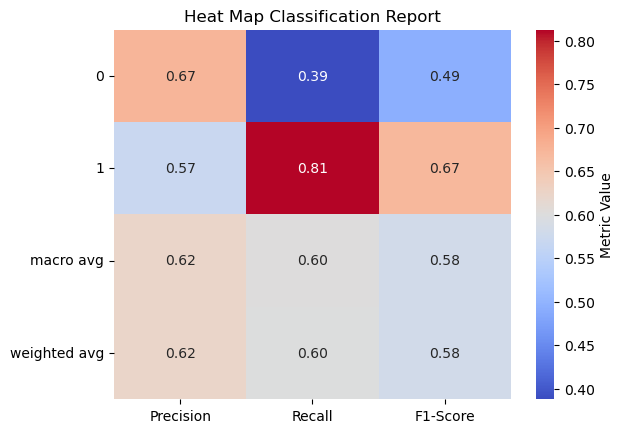

Normalized confusion matrix
------------
Test  identity


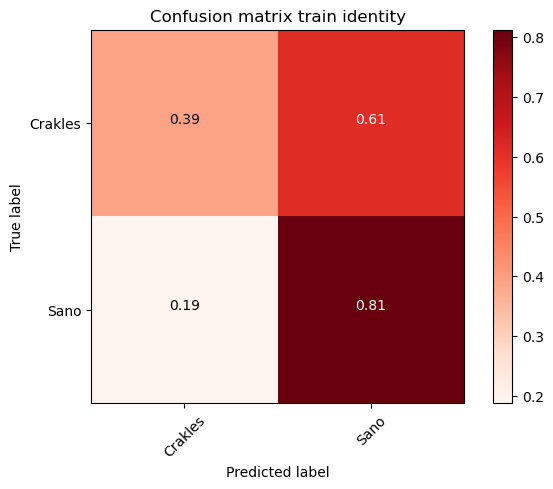

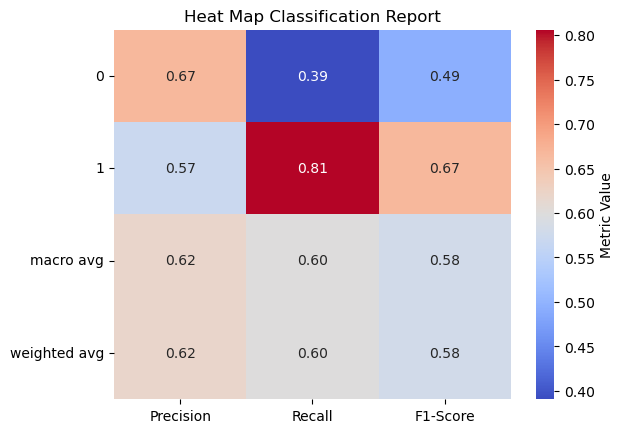

Normalized confusion matrix
Train  tanh
------------


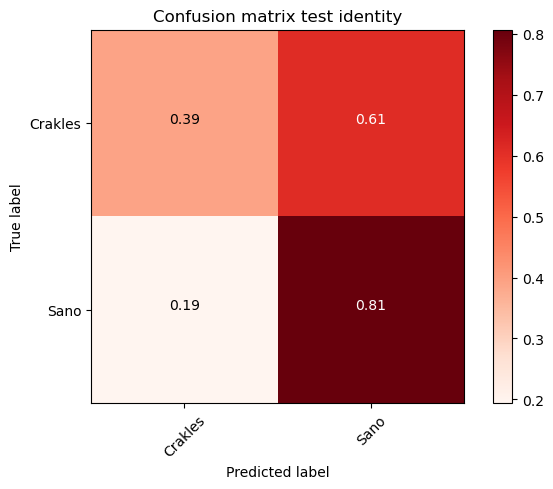

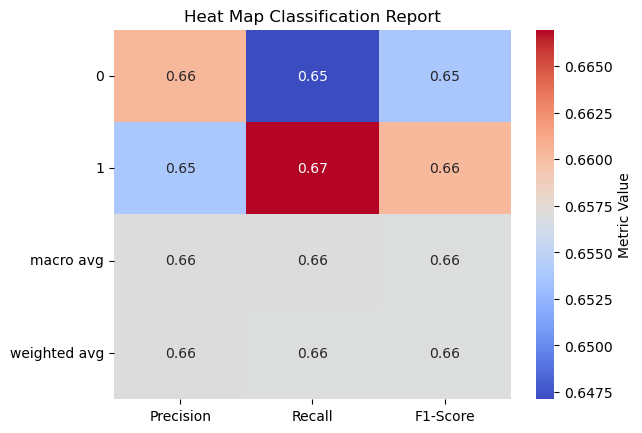

Normalized confusion matrix
------------
Test  tanh


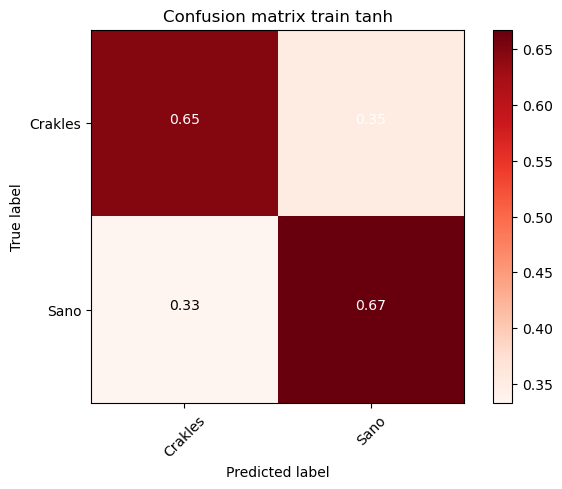

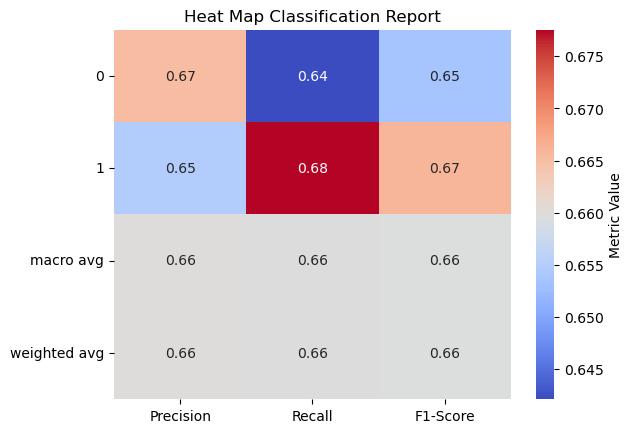

Normalized confusion matrix
Train  logistic
------------


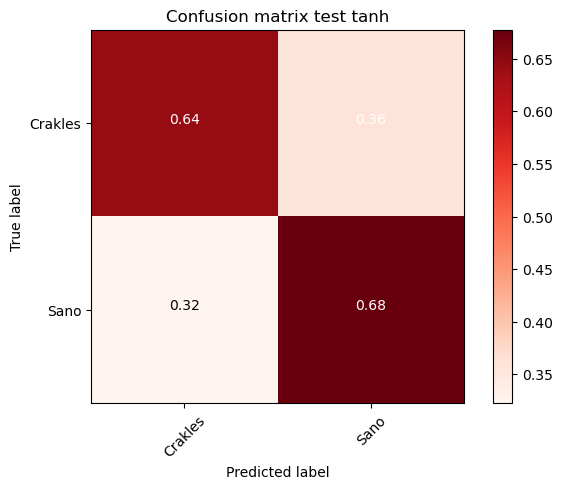

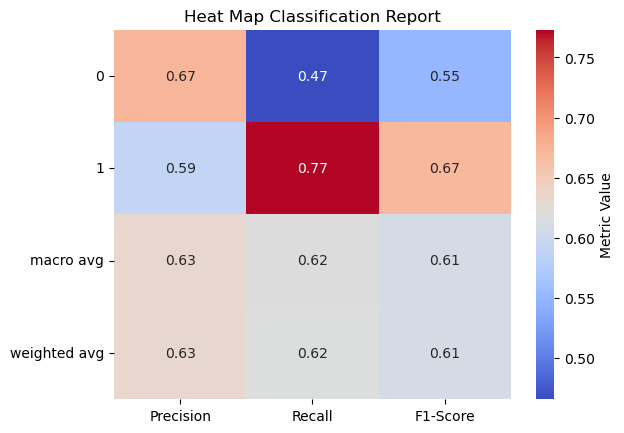

Normalized confusion matrix
------------
Test  logistic


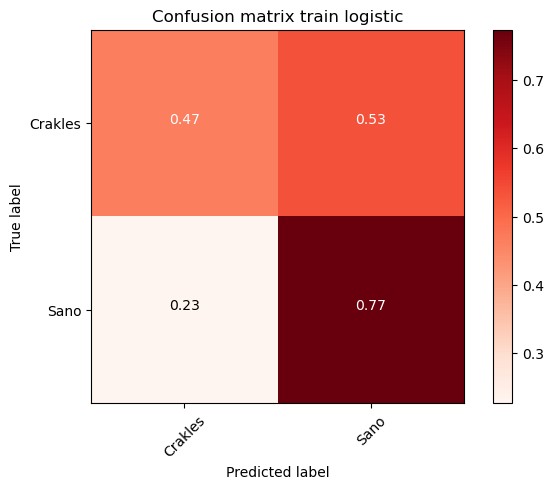

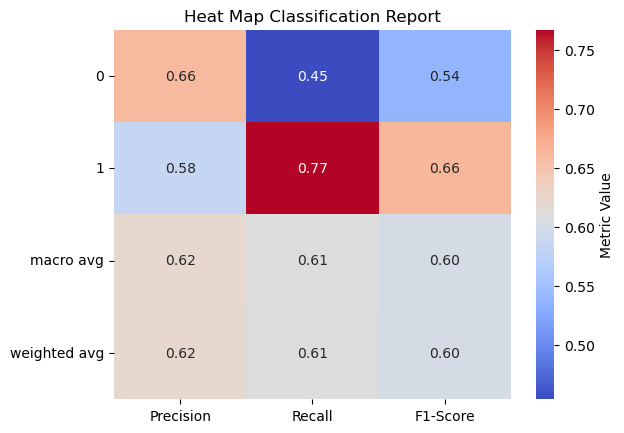

Normalized confusion matrix


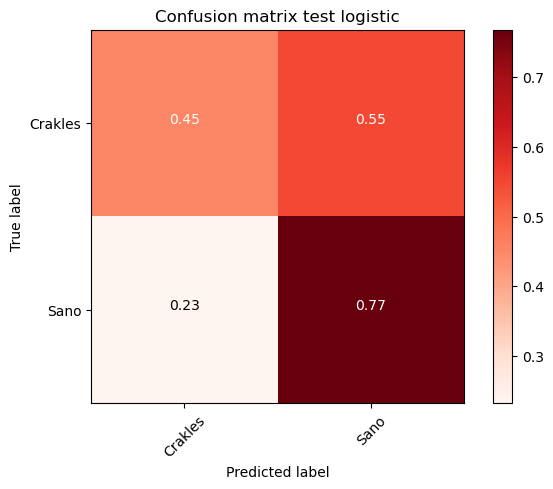

In [180]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Sano'])

### 1.2.2 Lo que no se pidió

In [181]:
max_iter=[10000]
it=list(tuple_generator1(1,20))
activation=['relu','identity','tanh','logistic']
param_grid = {'hidden_layer_sizes': it,"activation":activation,"max_iter":max_iter}
mlp= MLPClassifier(solver='adam')
grid_search = GridSearchCV(mlp, param_grid,
                           verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], 
                   activation=best_params["activation"], solver='adam', 
                   max_iter=best_params["max_iter"]) 
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (19, 19, 19), 'max_iter': 10000}
Best Score: -0.6348371208406831
Train  relu
------------


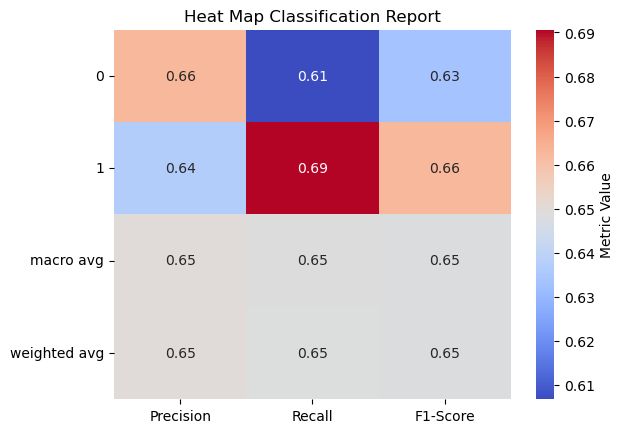

Normalized confusion matrix
------------
Test  relu


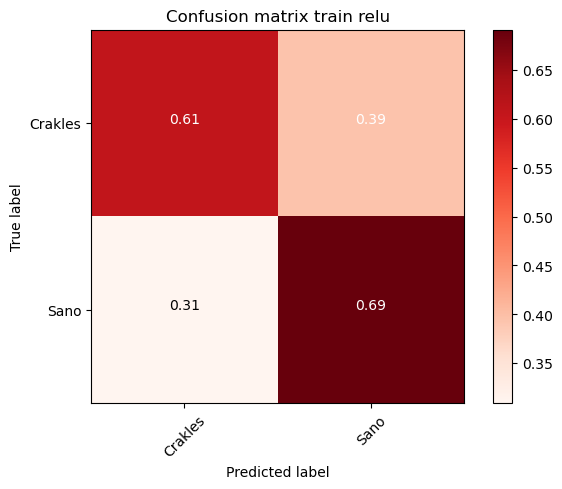

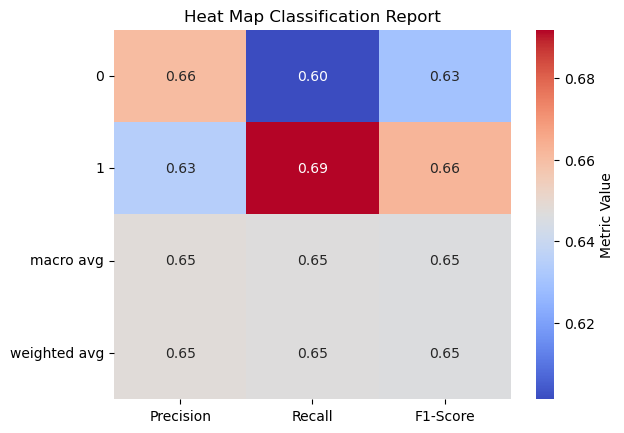

Normalized confusion matrix


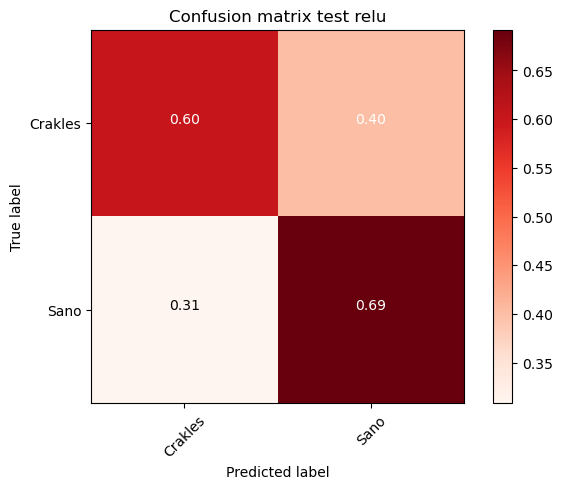

In [182]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Sano'])

In [183]:
sem,_,_=best.hidden_layer_sizes
if sem>5:
    start=sem-5
    end=sem
else:
    start=sem
    end=sem+5
it2=tuple_generator(start,end)
param_grid2 = {'hidden_layer_sizes': it2}
grid_search = GridSearchCV(best, param_grid2,
                           verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"],
                           activation=best.activation, 
                           solver='adam',
                             max_iter=best.max_iter) 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Best Parameters: {'hidden_layer_sizes': (19, 16, 16)}
Best Score: -0.644473585804958
Train  relu
------------


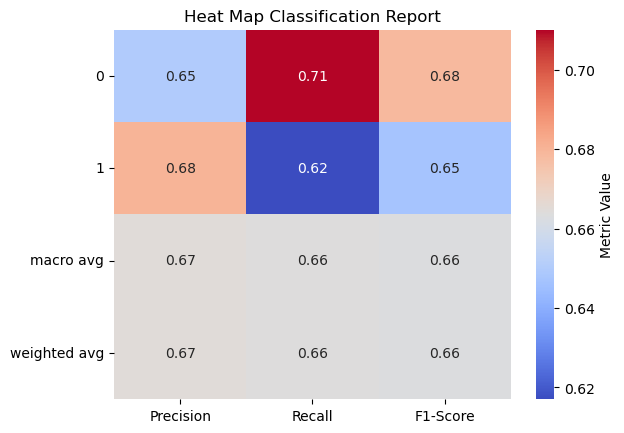

Normalized confusion matrix
------------
Test  relu


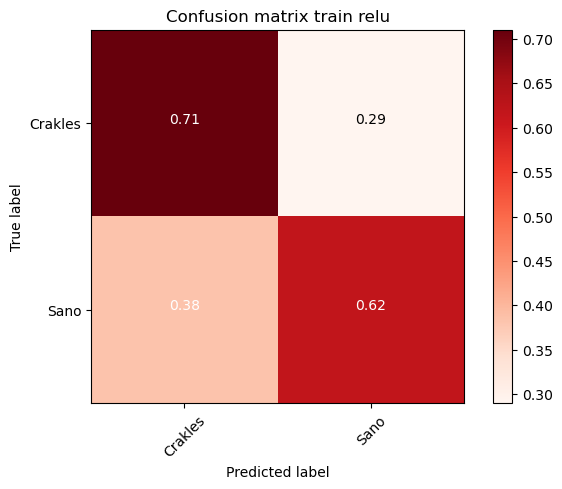

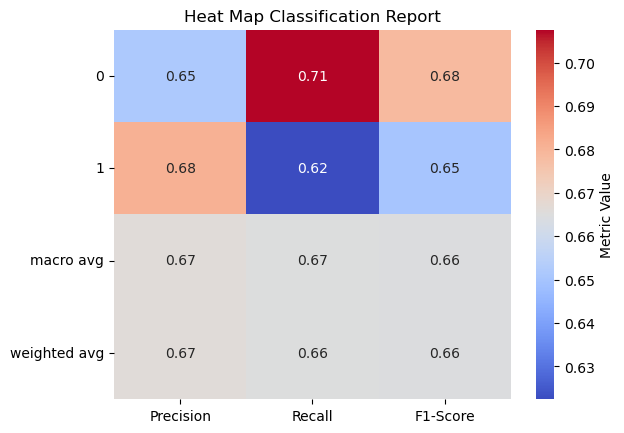

Normalized confusion matrix


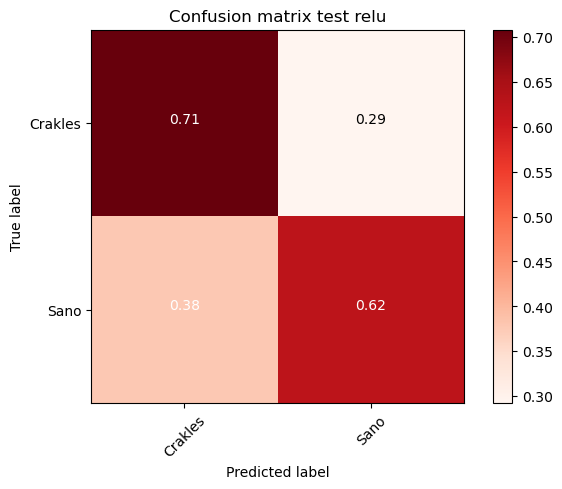

In [184]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Sano'])

# 2. Ciclos normales y ciclos silbantes

### 2.1 Lo que pide el trabajo:

In [185]:
d=d2[d2["Estado"]==1].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2]))]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
np.putmask(y,y == 2,0)
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)

print (Xtv.shape, Xts.shape)



(1310, 3) (1310,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(917, 3) (393, 3)


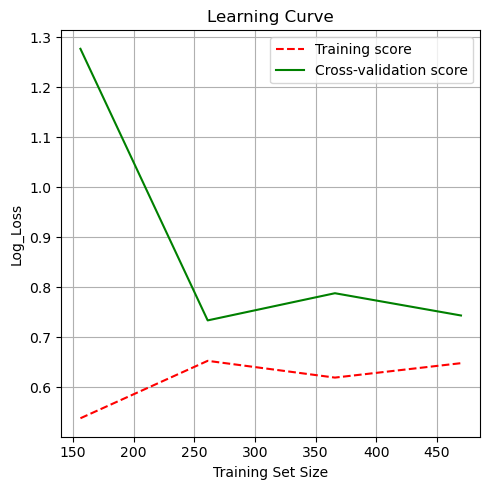

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [186]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------


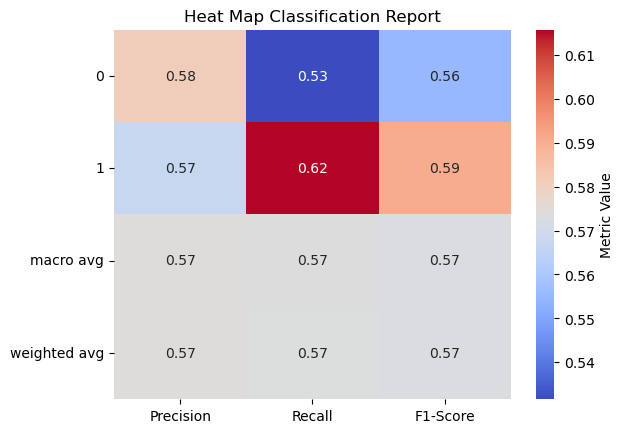

Normalized confusion matrix
------------
Test  relu


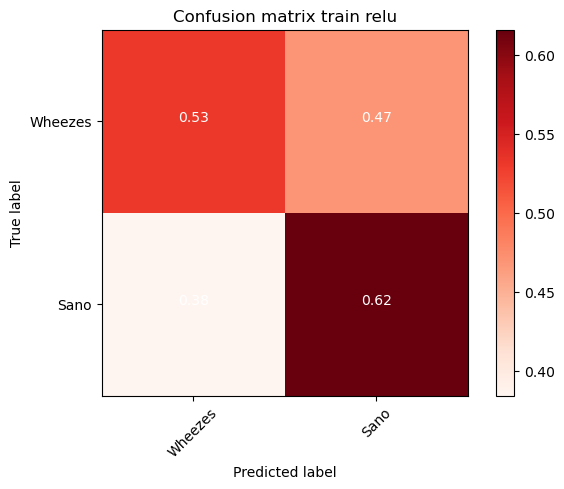

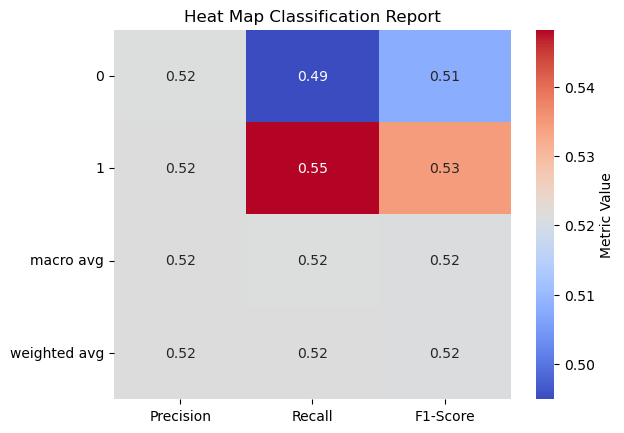

Normalized confusion matrix
Train  identity
------------


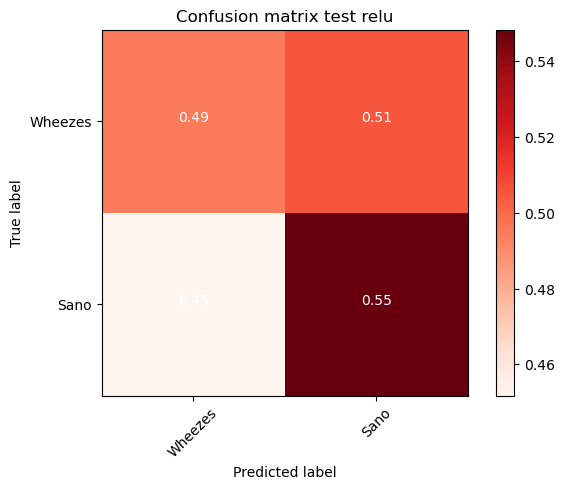

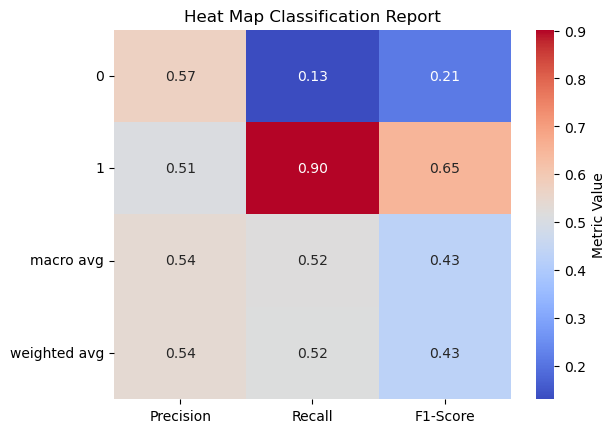

Normalized confusion matrix
------------
Test  identity


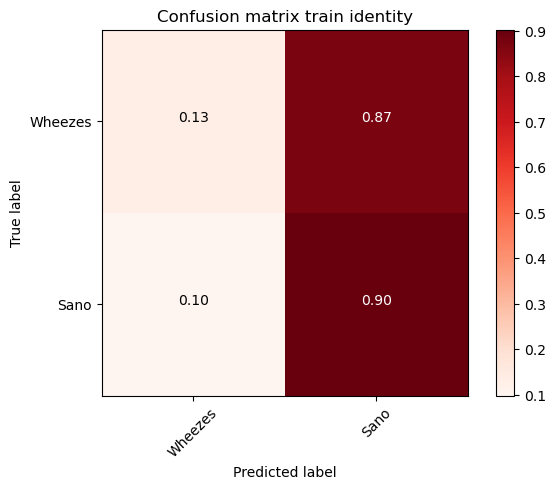

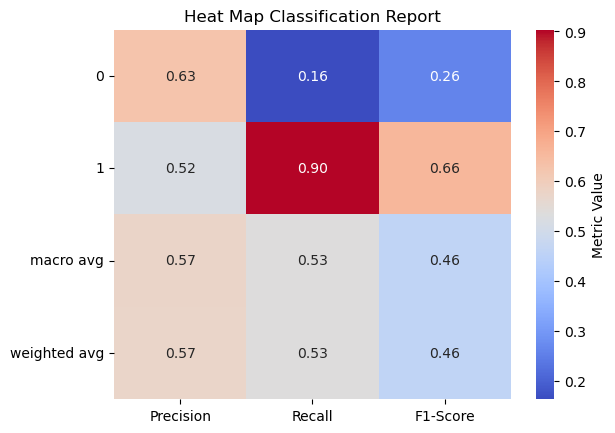

Normalized confusion matrix
Train  tanh
------------


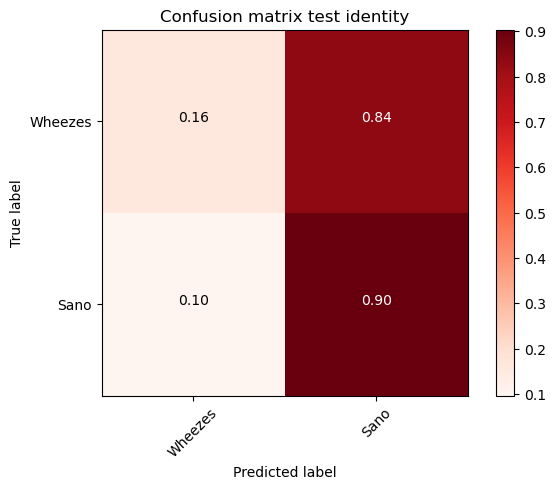

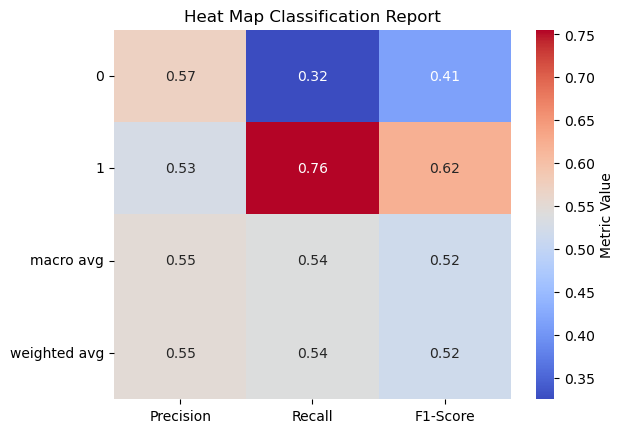

Normalized confusion matrix
------------
Test  tanh


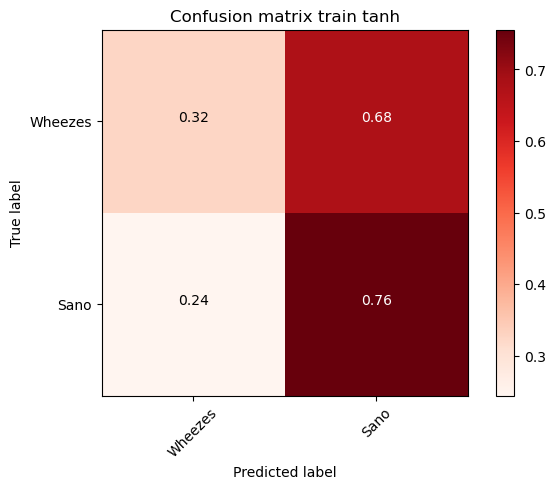

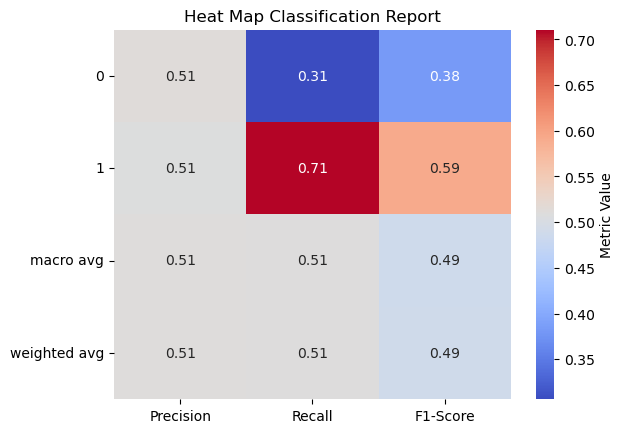

Normalized confusion matrix
Train  logistic
------------


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


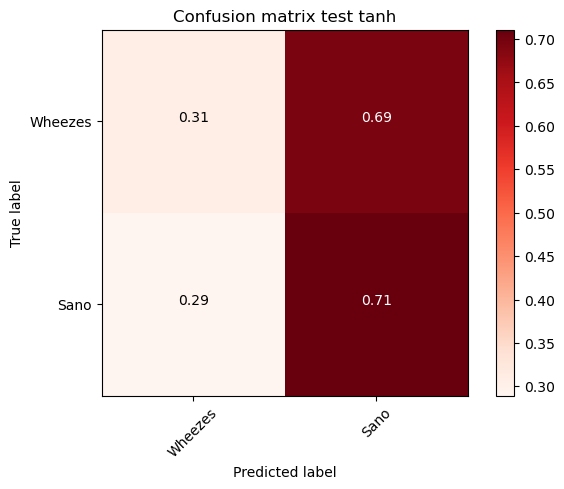

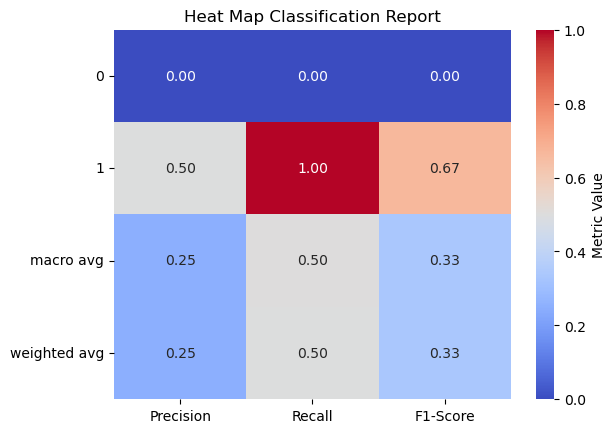

Normalized confusion matrix
------------
Test  logistic


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


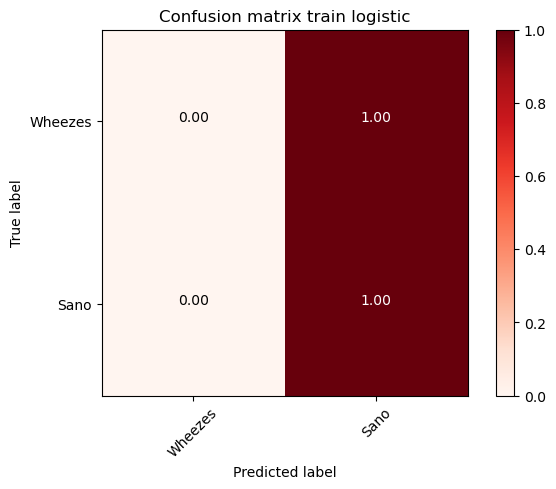

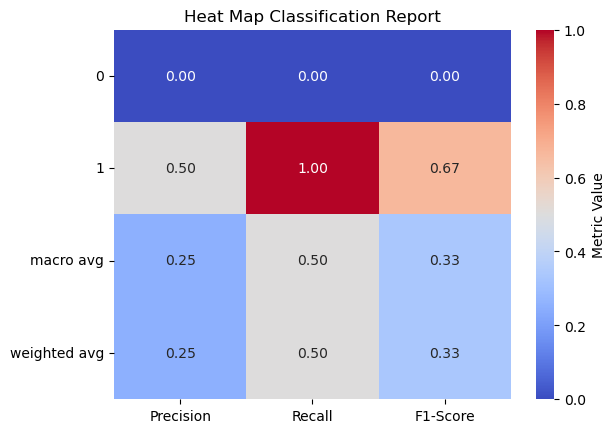

Normalized confusion matrix


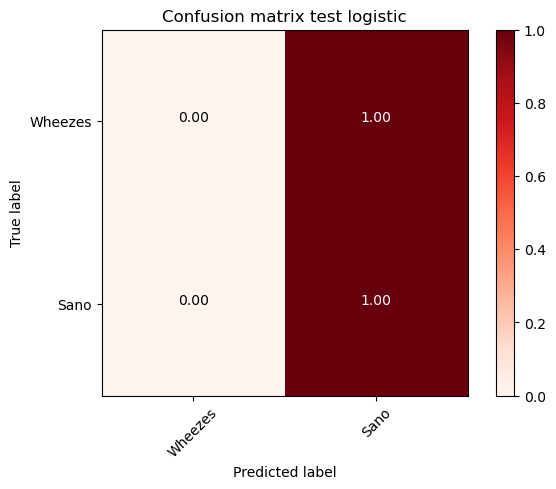

In [187]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Wheezes','Sano'])

## 2.2 La optimización porque no voy a perder lo que estudie en IA

In [188]:

mlp= MLPClassifier(solver='adam')
grid_search = GridSearchCV(mlp, param_grid
                           ,verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"],
                    activation=best_params["activation"], solver='adam', 
                    max_iter=best_params["max_iter"]) 


Fitting 5 folds for each of 80 candidates, totalling 400 fits


Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (4, 4, 4), 'max_iter': 10000}
Best Score: -0.6936236892786127
Train  relu
------------


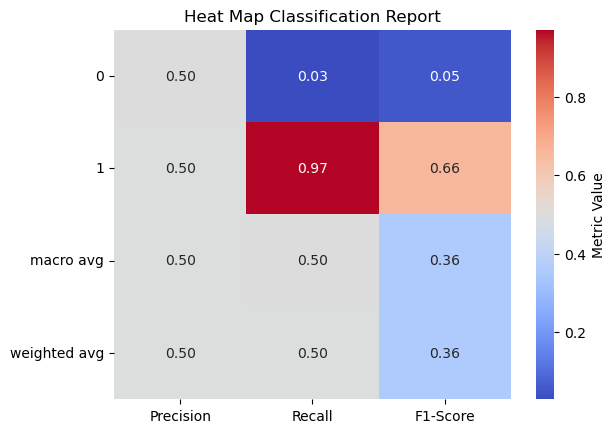

Normalized confusion matrix
------------
Test  relu


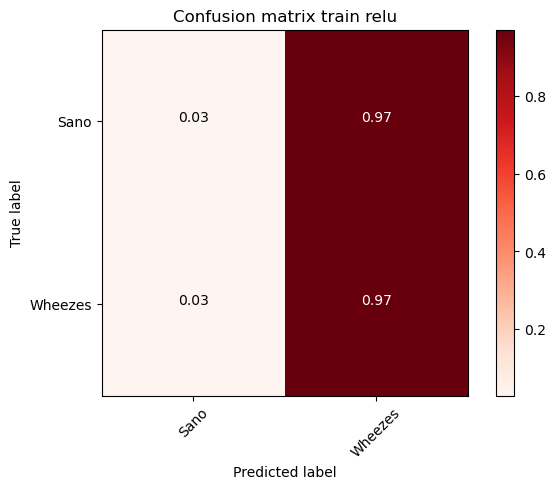

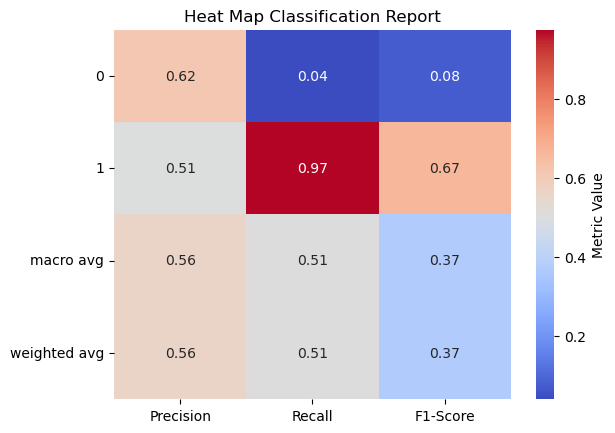

Normalized confusion matrix
MLPClassifier(hidden_layer_sizes=(4, 4, 4), max_iter=10000)


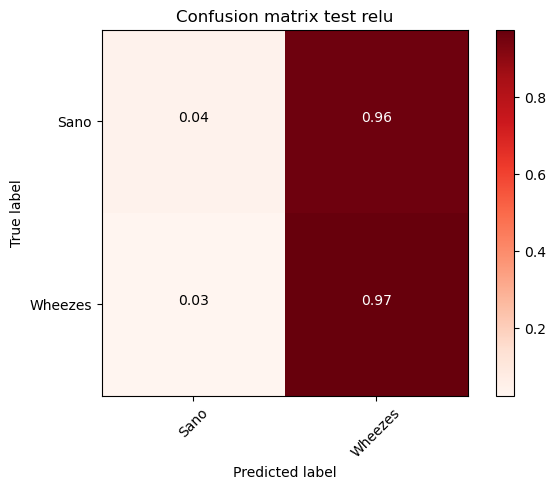

In [189]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Wheezes'])
print(best)

In [190]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>5:
    start=sem-5
    end=sem
else:
    start=sem
    end=sem+5
it2=tuple_generator(start,end)
param_grid2 = {'hidden_layer_sizes': it2}
grid_search = GridSearchCV(best, param_grid2,
                           verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Best Parameters: {'hidden_layer_sizes': (8, 8, 7)}
Best Score: -0.691674530054095
Train  relu
------------


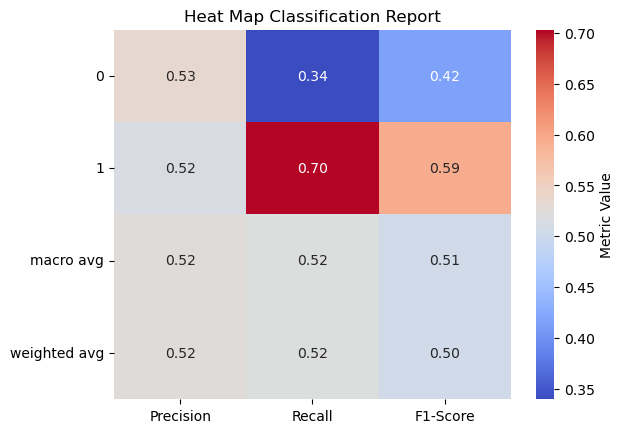

Normalized confusion matrix
------------
Test  relu


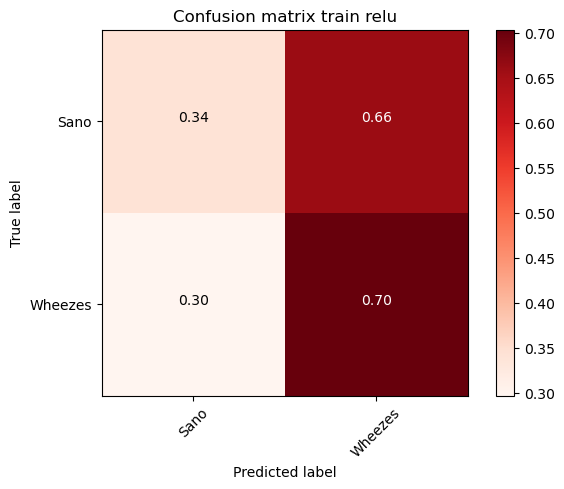

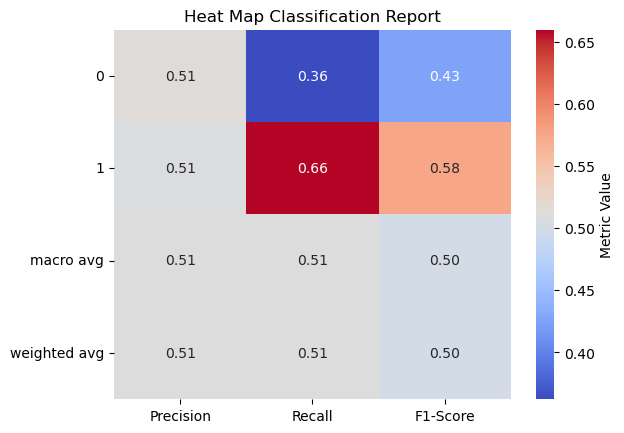

Normalized confusion matrix


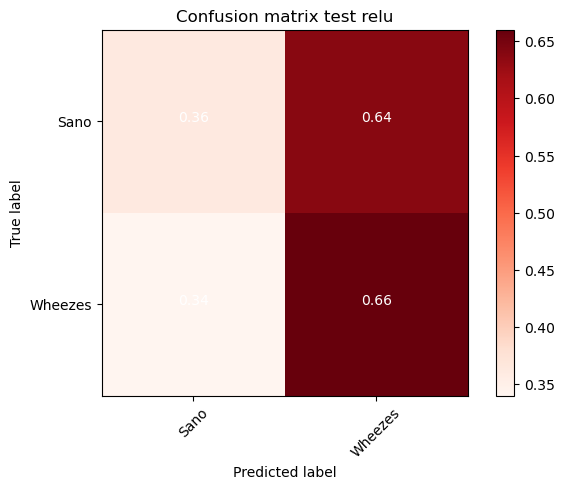

In [191]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## 3. Silibantes y crepitantes

## Lo que si 

In [192]:
d=d2[d2["Estado"]==0].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2]))]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
np.putmask(y,y == 2,1)
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)

scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)

(1310, 3) (1310,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(917, 3) (393, 3)


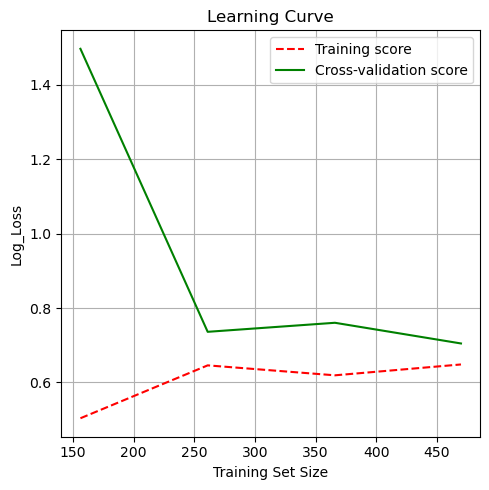

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [193]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------


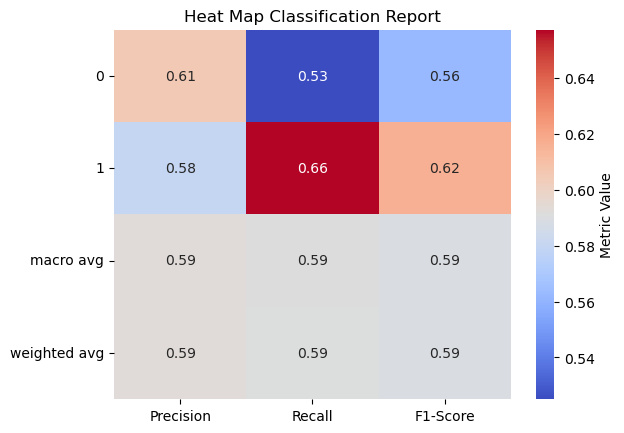

Normalized confusion matrix
------------
Test  relu


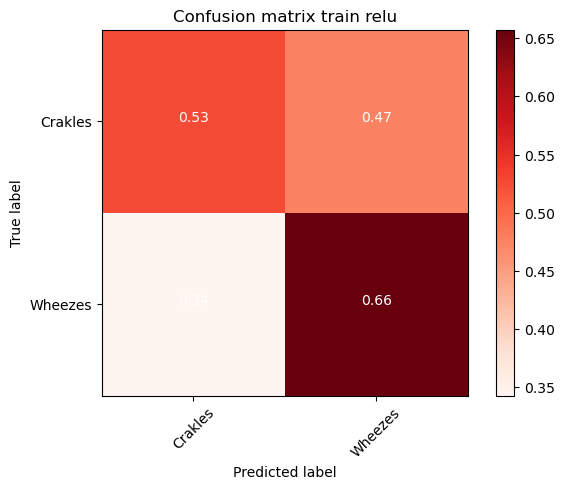

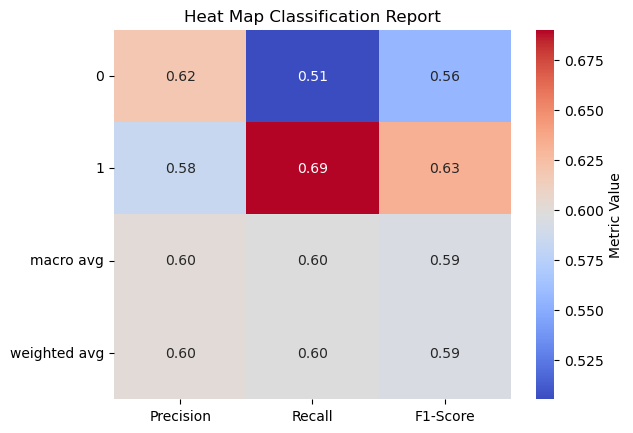

Normalized confusion matrix
Train  identity
------------


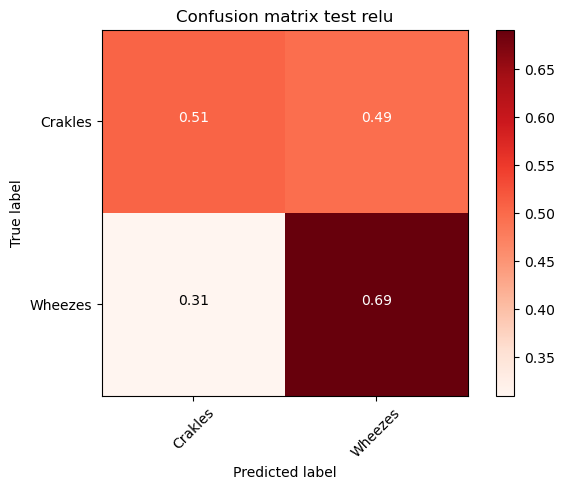

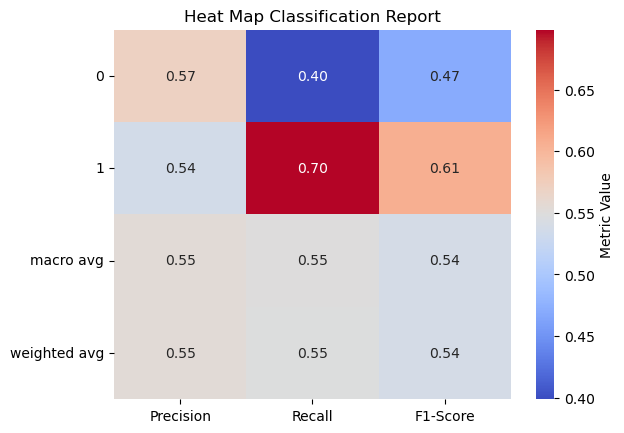

Normalized confusion matrix
------------
Test  identity


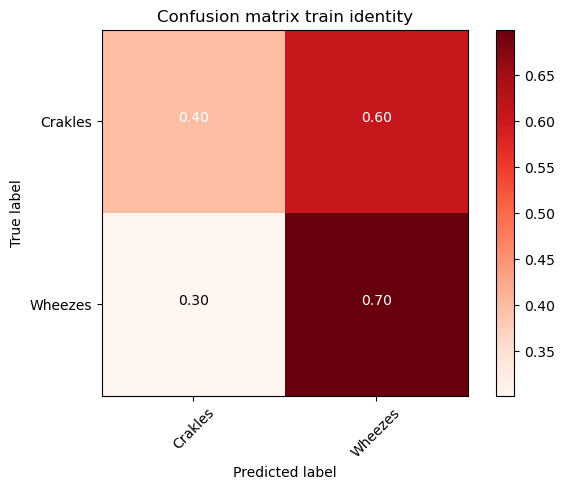

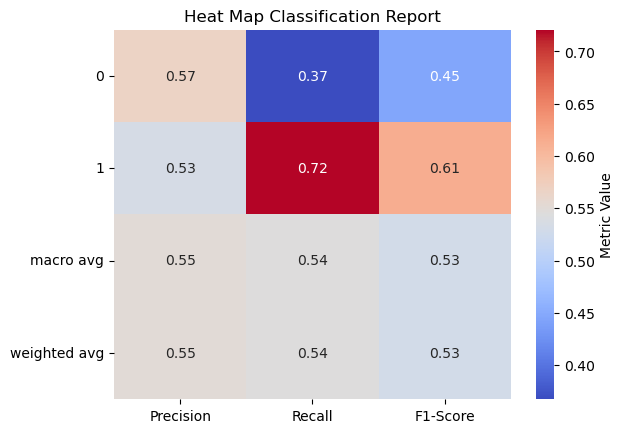

Normalized confusion matrix
Train  tanh
------------


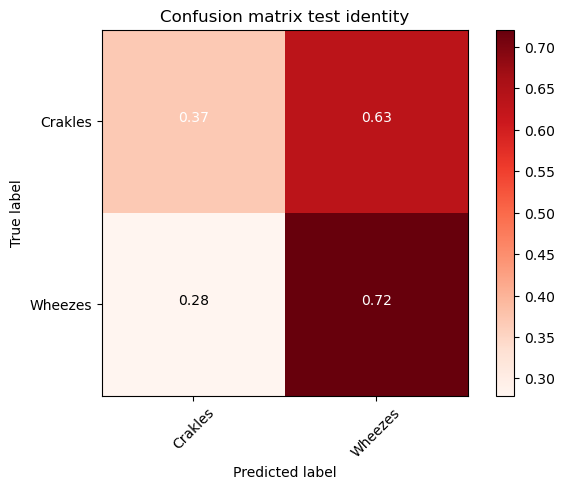

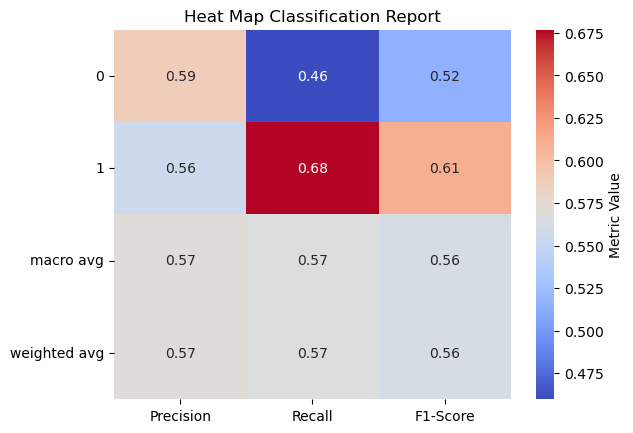

Normalized confusion matrix
------------
Test  tanh


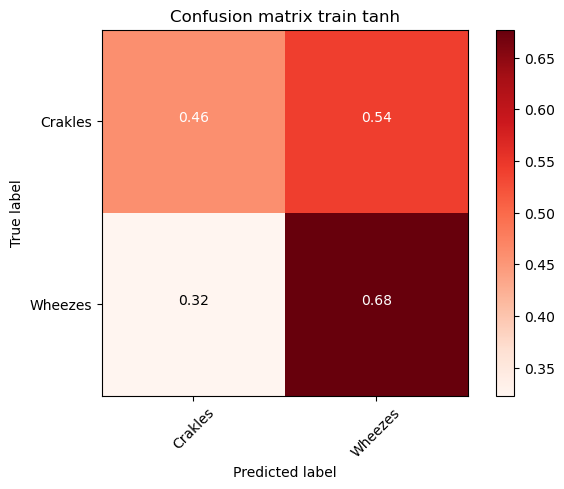

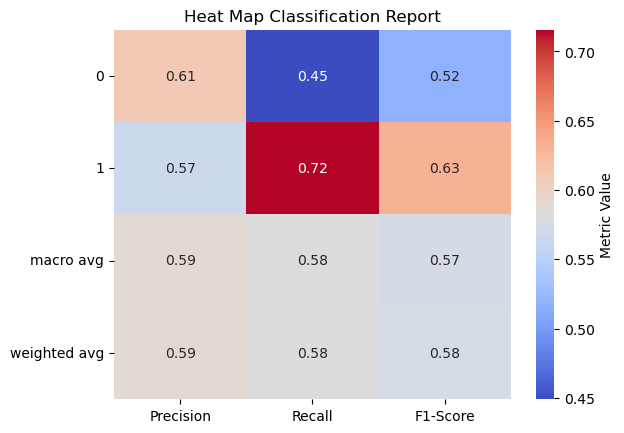

Normalized confusion matrix
Train  logistic
------------


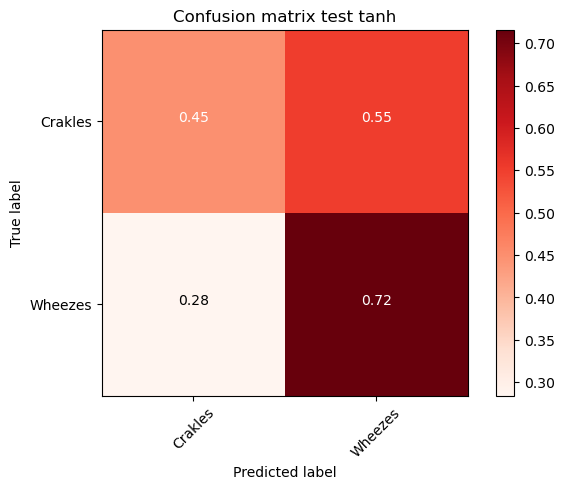

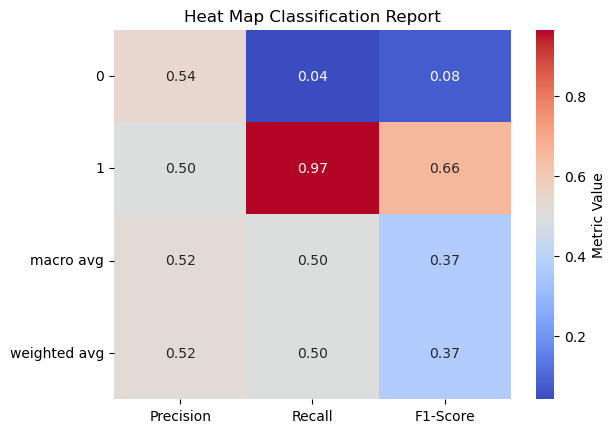

Normalized confusion matrix
------------
Test  logistic


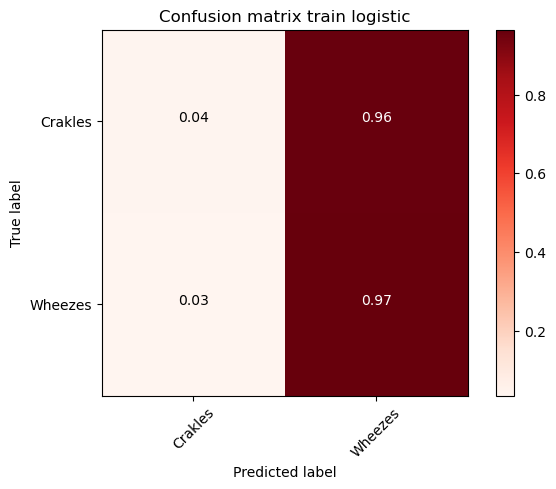

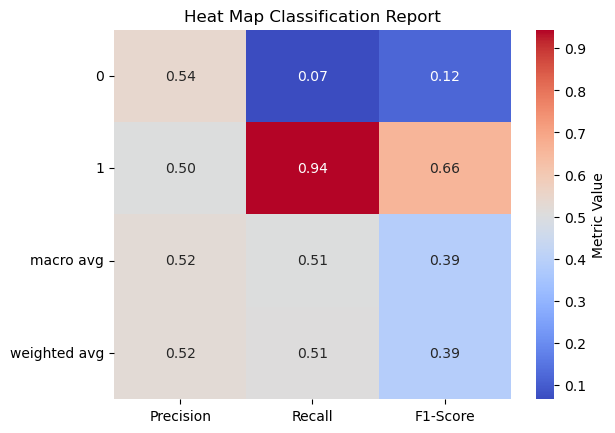

Normalized confusion matrix


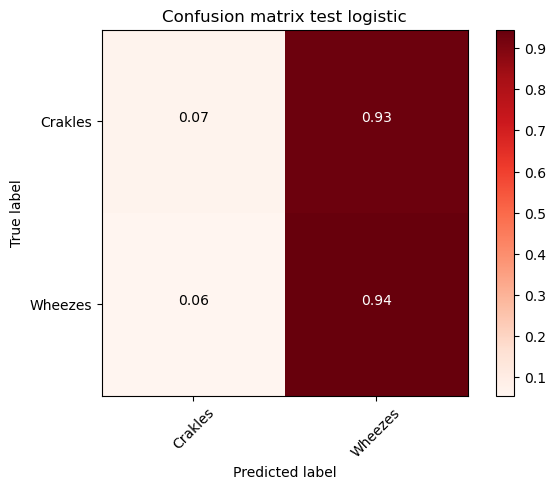

In [194]:

mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

## Lo que espero que nos den más nota:

In [195]:

mlp= MLPClassifier(solver='adam')
grid_search = GridSearchCV(mlp, param_grid
                           ,verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"],
                    activation=best_params["activation"],
                      solver='adam', max_iter=best_params["max_iter"]) 

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (5, 5, 5), 'max_iter': 10000}
Best Score: -0.6900267013975266
Train  tanh
------------


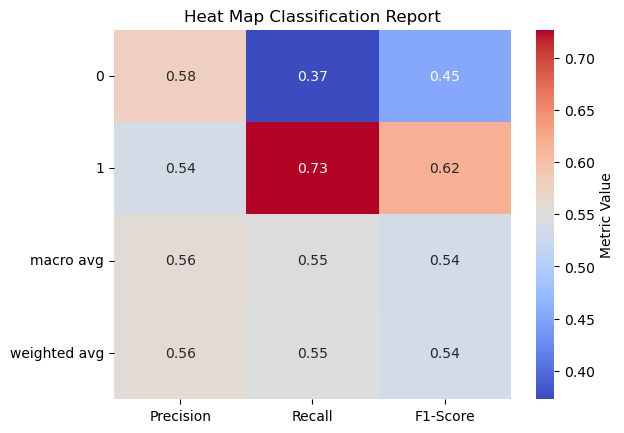

Normalized confusion matrix
------------
Test  tanh


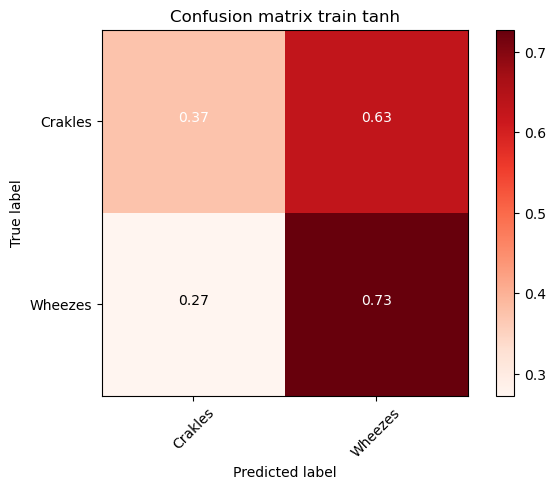

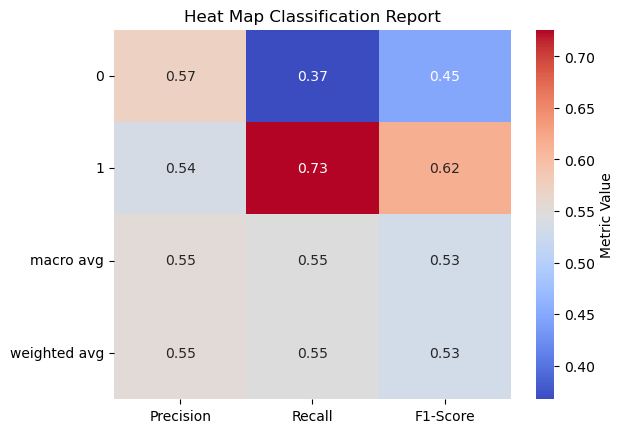

Normalized confusion matrix
MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5, 5), max_iter=10000)


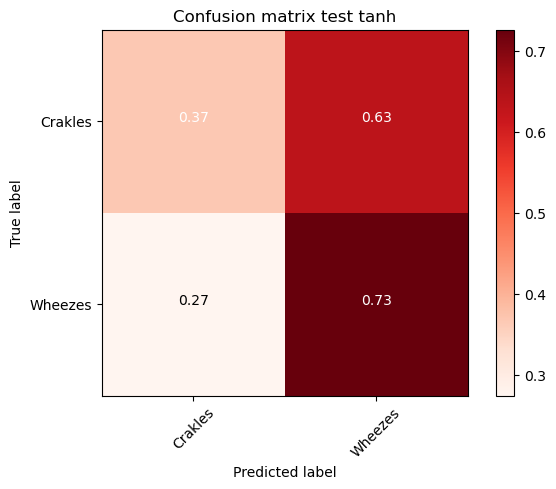

In [196]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])
print(best)

In [197]:
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>5:
    start=sem-5
    end=sem
else:
    start=sem
    end=sem+5
it2=tuple_generator(start,end)
param_grid2 = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid2,
                           verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best Parameters: {'hidden_layer_sizes': (5, 5, 5)}
Best Score: -0.6944664003004293
Train  tanh
------------


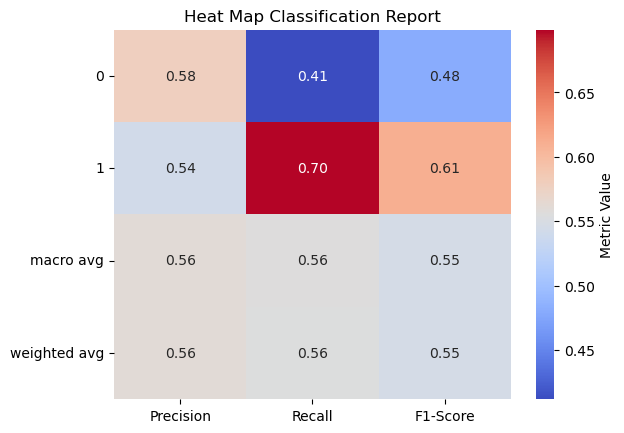

Normalized confusion matrix
------------
Test  tanh


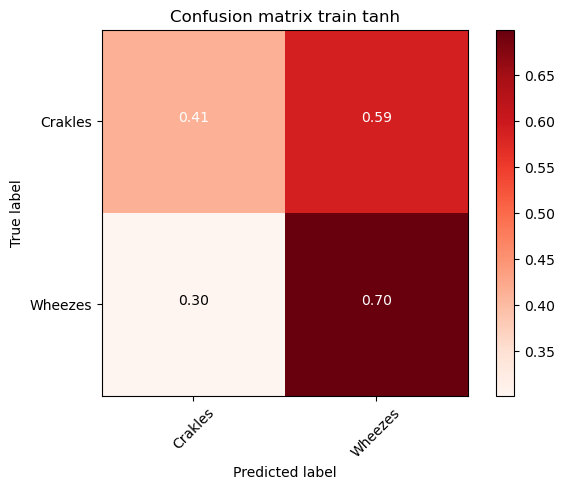

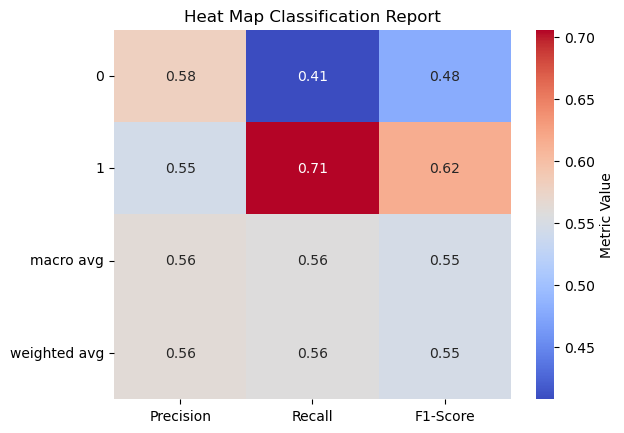

Normalized confusion matrix


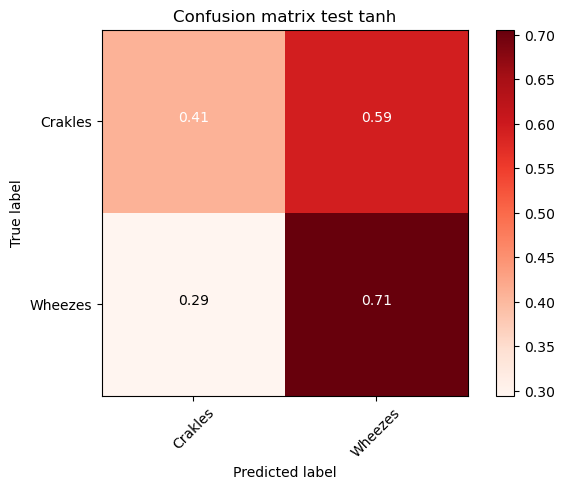

In [198]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], 
                          activation=best.activation, 
                          solver='adam', 
                          max_iter=best.max_iter) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

# 4. Normales, silibantes y crepitantes

## Franklin perdón si llegas hasta aquí

In [199]:
d=d2[d2["Estado"]==0].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d1=d2[d2["Estado"]==1].sample(frac=1, random_state=23)
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2]))],d1[:int(len(d2[d2["Estado"]==2]))] ])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)


(1965, 3) (1965,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1375, 3) (590, 3)


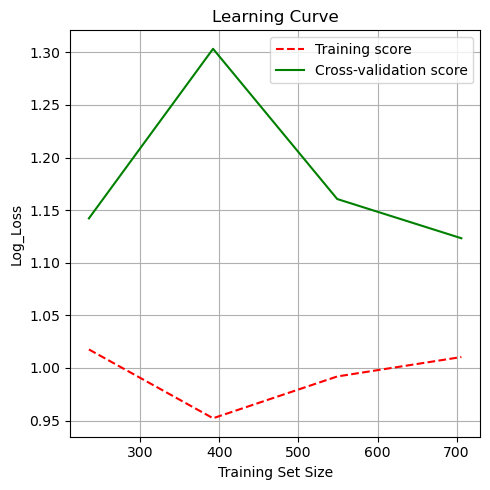

<module 'matplotlib.pyplot' from 'c:\\Users\\MIGUEL\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [200]:
mlp= MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu',solver='adam', max_iter=10000)
lc_plot(mlp,Xtv,ytv)

Train  relu
------------


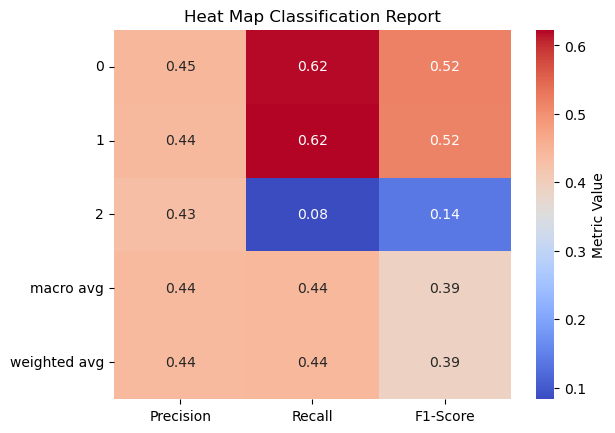

Normalized confusion matrix
------------
Test  relu


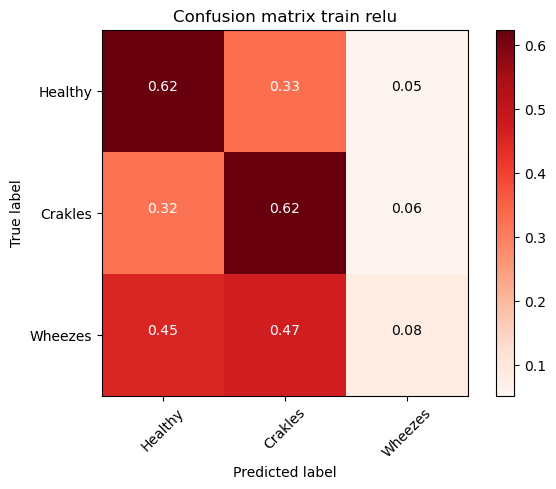

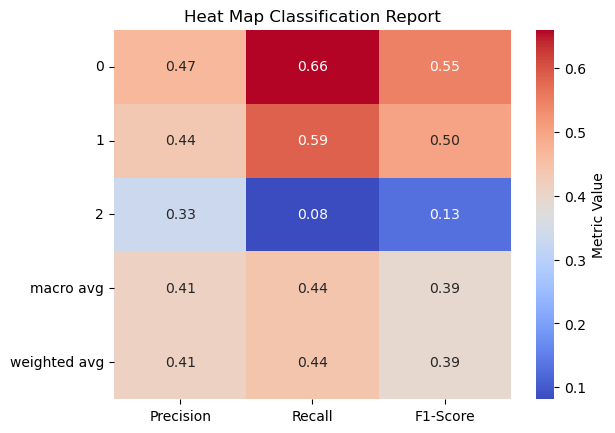

Normalized confusion matrix
Train  identity
------------


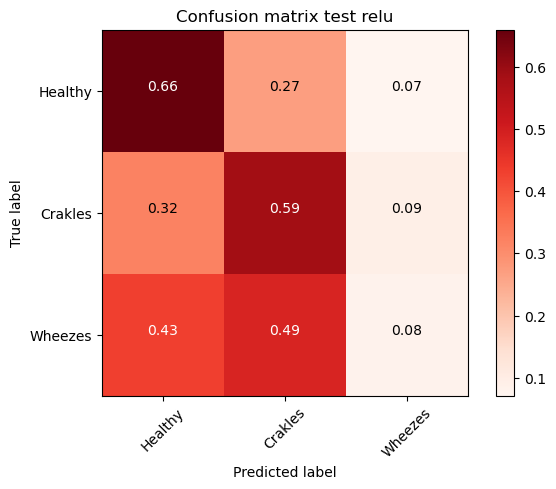

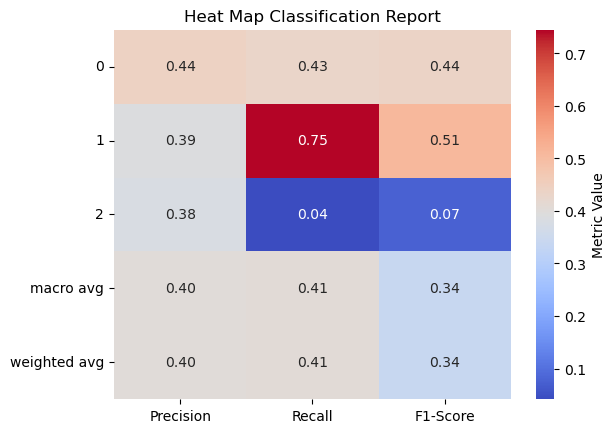

Normalized confusion matrix
------------
Test  identity


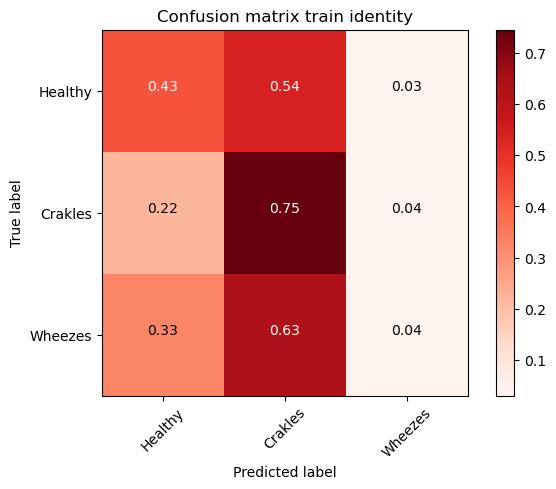

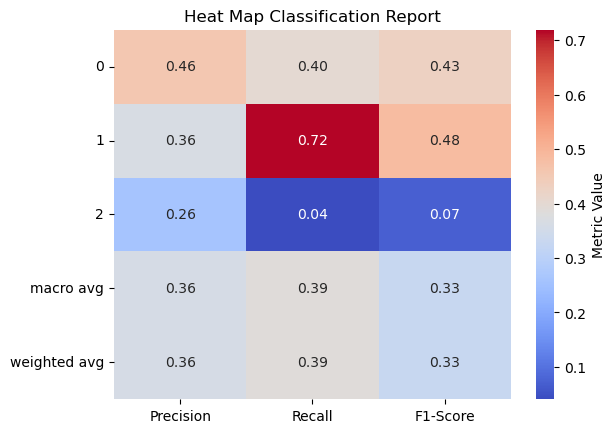

Normalized confusion matrix
Train  tanh
------------


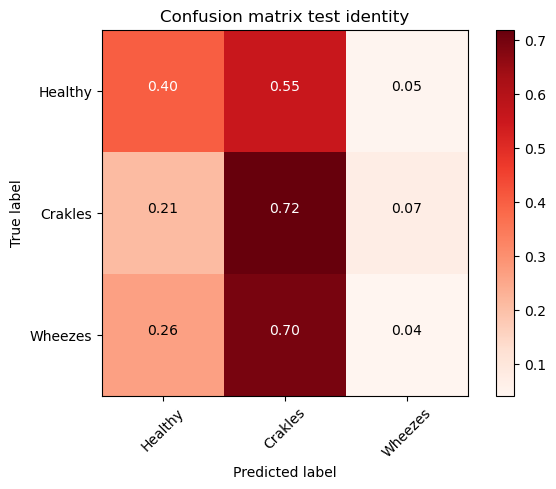

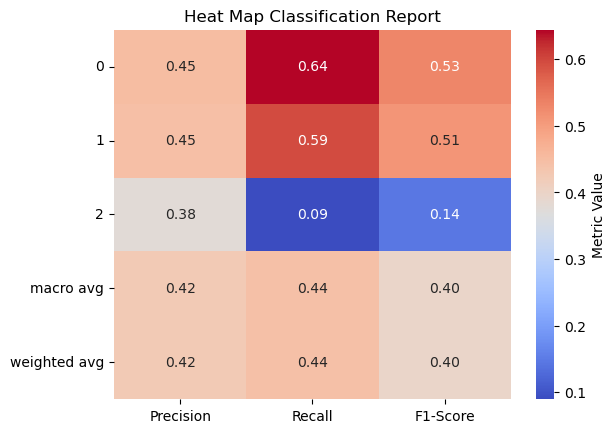

Normalized confusion matrix
------------
Test  tanh


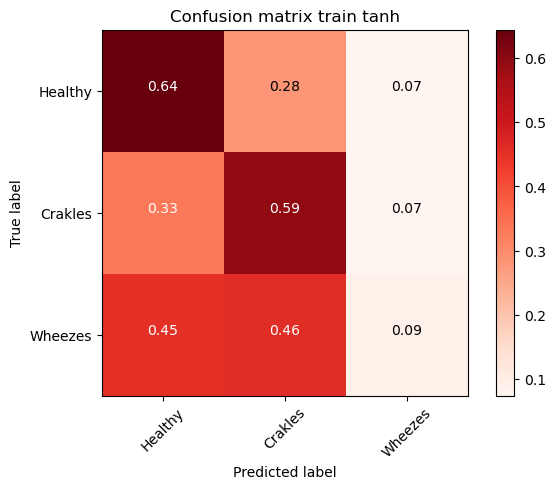

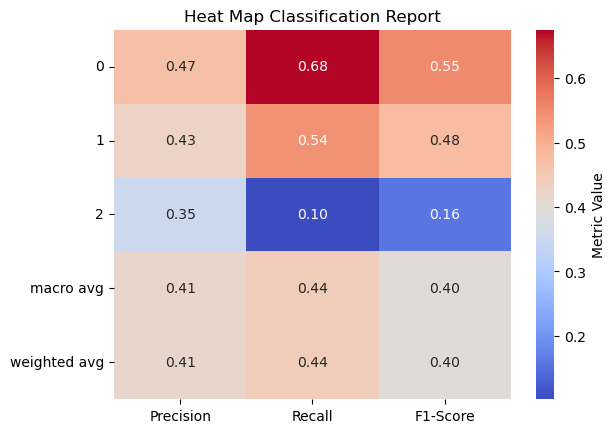

Normalized confusion matrix
Train  logistic
------------


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


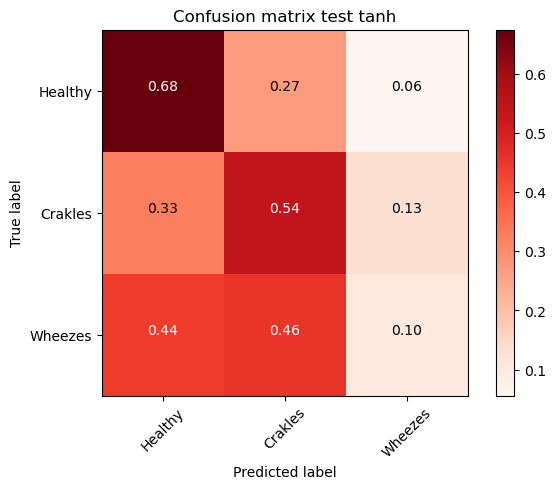

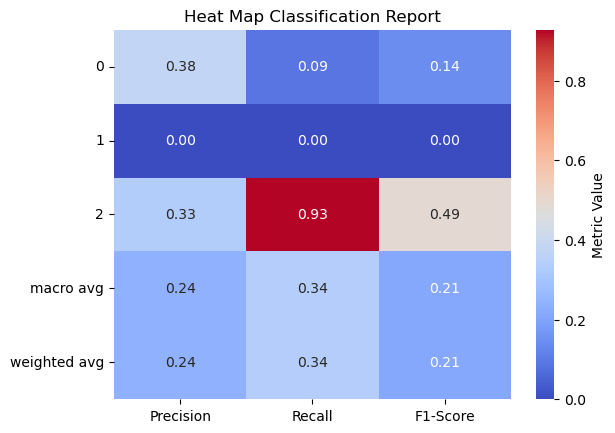

Normalized confusion matrix
------------
Test  logistic


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


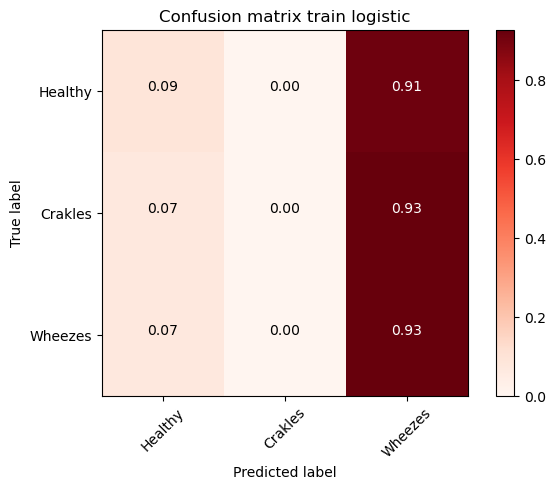

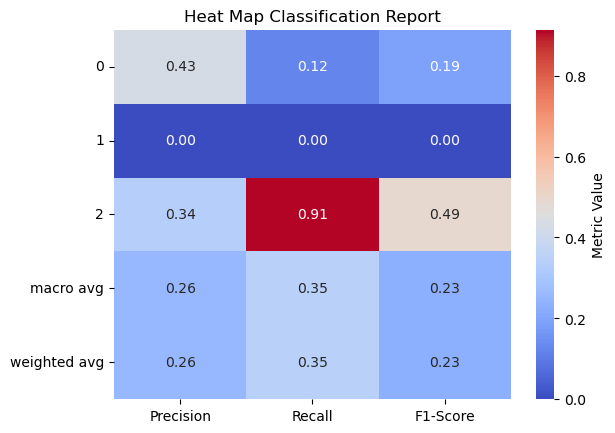

Normalized confusion matrix


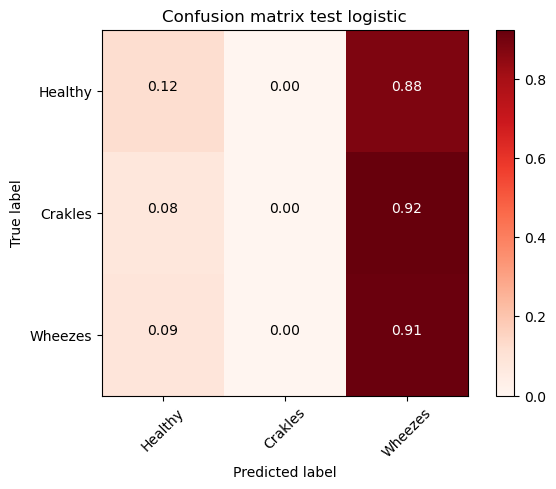

In [201]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])

## Dormir esta sobrevalorado 

In [202]:
mlp= MLPClassifier(solver='adam')
grid_search = GridSearchCV(mlp, 
                           param_grid,
                           verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
#Se crea la mejor red neuronal posible con los parametros anteriores
best=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], 
                   activation=best_params["activation"], solver='adam',
                     max_iter=best_params["max_iter"]) 

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (9, 9, 9), 'max_iter': 10000}
Best Score: -1.0913183412554601
Train  tanh
------------


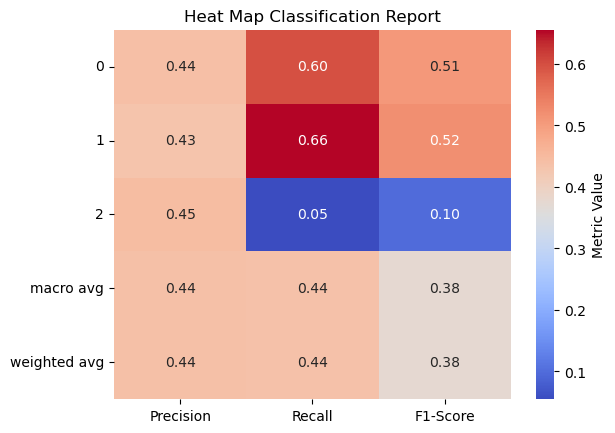

Normalized confusion matrix
------------
Test  tanh


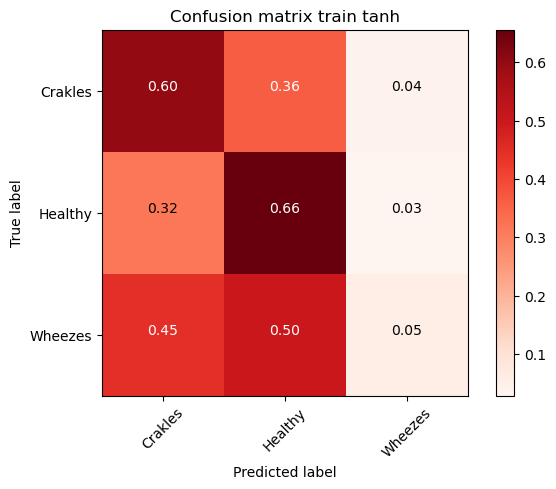

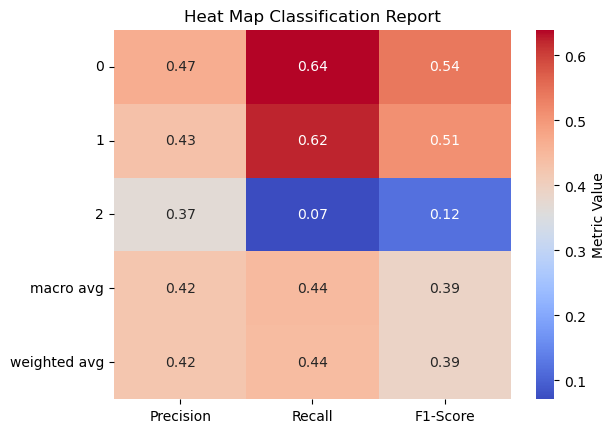

Normalized confusion matrix


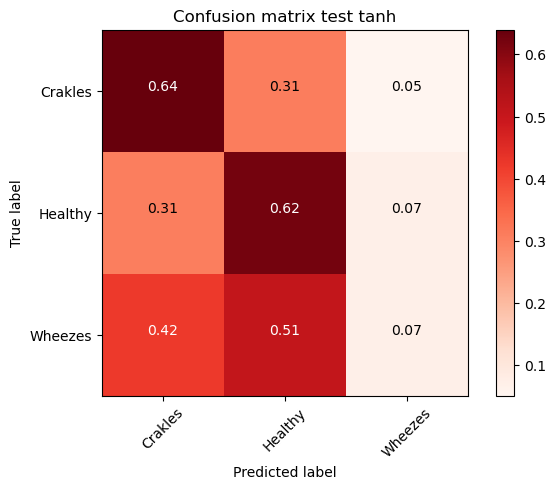

In [203]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
metrics(best,Xtv,ytv,Xts,yts,['Crakles',"Healthy",'Wheezes'])

In [204]:

sem,_,_=best.hidden_layer_sizes
if sem>5:
    start=sem-5
    end=sem
else:
    start=sem
    end=sem+5
it2=tuple_generator(start,end)
param_grid2 = {'hidden_layer_sizes': it2}
grid_search = GridSearchCV(best, param_grid2,
                            verbose=2,scoring="neg_log_loss",
                            cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Best Parameters: {'hidden_layer_sizes': (9, 9, 8)}
Best Score: -1.0856731576765664
Train  tanh
------------


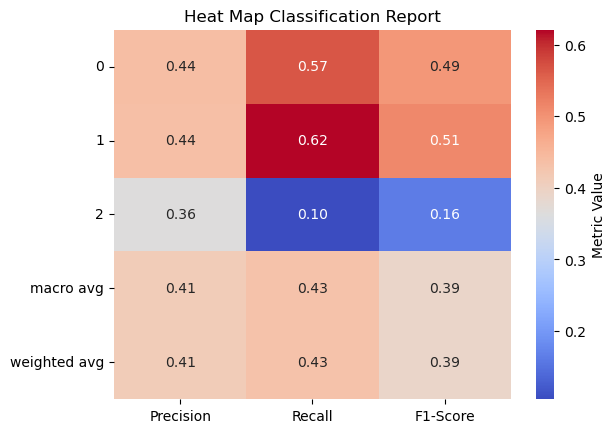

Normalized confusion matrix
------------
Test  tanh


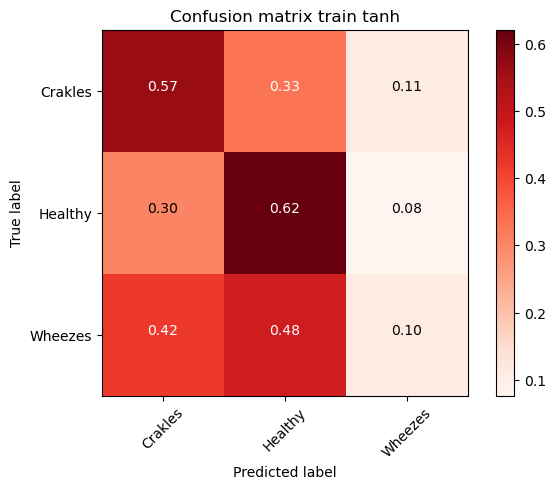

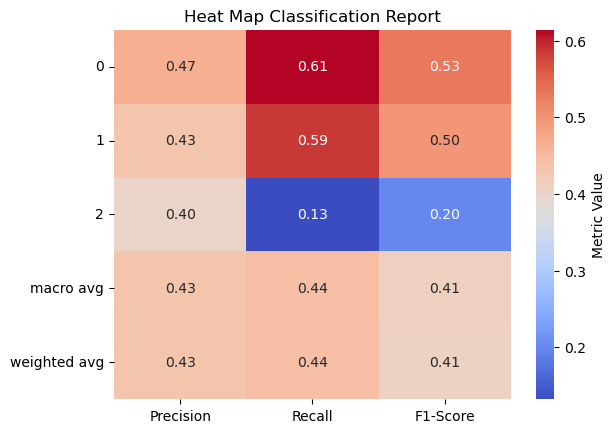

Normalized confusion matrix


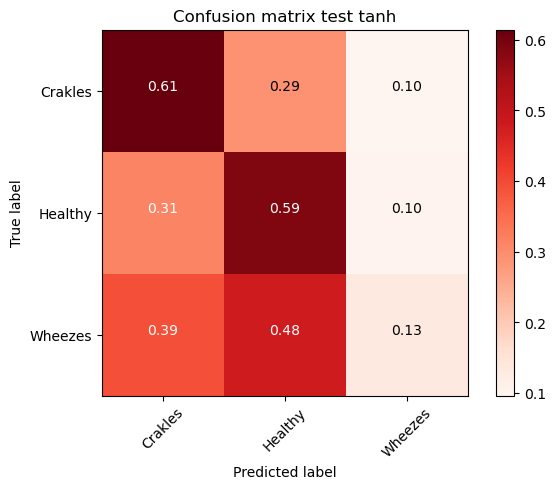

In [205]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], 
                          activation=best.activation, solver='adam', max_iter=best.max_iter) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles',"Healthy",'Wheezes'])

# 5 Kmeans

In [206]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from mpl_toolkits.mplot3d import Axes3D

In [207]:
def plot_clusters(X,y):
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters==2 else plt.cm.plasma
    cmap((y*255./(n_clusters-1)).astype(int))
    for i in np.unique(y):
        col = cmap((i*255./(n_clusters-1)).astype(int))
        Xr = X[y==i]
        plt.scatter(Xr[:,0], Xr[:,1], color=col, label="cluster %d"%i, alpha=.5)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],marker="x", lw=5, s=200, color="black")
    plt.legend()    
    plt.xlabel("Varianza normalizada")
    plt.ylabel("Mediana normalizada");

In [208]:
def plot_clusters3D(X, y,plotcenter=False):
    name=["Crackles","Healthy","Silibantes"]
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters == 2 else plt.cm.plasma
    cmap((y * 255. / (n_clusters - 1)).astype(int))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in np.unique(y):
        col = cmap((i * 255. / (n_clusters - 1)).astype(int))
        Xr = X[y == i]
        ax.scatter(Xr[:, 0], Xr[:, 1], Xr[:, 2], color=col, label=name[i], alpha=.5)
    if plotcenter:
        ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], km.cluster_centers_[:, 2],
                marker="x", lw=5, s=200, color="black")
    
    ax.legend(loc="best")
    ax.set_zlabel("Varianza normalizada")
    ax.set_ylabel("Mediana normalizada")
    ax.set_xlabel("Sumatoria normalizada")
    
    plt.show()

In [209]:
def plot_clusters_2d(X, y, centers,plotcenter=False):
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters == 2 else plt.cm.plasma
    cmap((y * 255. / (n_clusters - 1)).astype(int))
    name=["Crackles","Healthy","Silibantes"]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].set_xlabel("Sumatoria normalizada")
    axs[0].set_ylabel("Mediana normalizada")
    axs[1].set_xlabel("Sumatoria normalizada")
    axs[1].set_ylabel("Varianza normalizada")
    axs[2].set_xlabel("Mediana normalizada")
    axs[2].set_ylabel("Varianza normalizada")

    for i in np.unique(y):
        col = cmap((i * 255. / (n_clusters - 1)).astype(int))
        Xr = X[y == i]
        axs[0].scatter(Xr[:, 0], Xr[:, 1], color=col, label=name[i], alpha=.5)
        axs[1].scatter(Xr[:, 0], Xr[:, 2], color=col, label=name[i], alpha=.5)
        axs[2].scatter(Xr[:, 1], Xr[:, 2], color=col, label=name[i], alpha=.5)
    if plotcenter:
        axs[0].scatter(centers[:, 0], centers[:, 1], marker="x", color="black", label="Cluster Centers")
        axs[1].scatter(centers[:, 0], centers[:, 2], marker="x", color="black", label="Cluster Centers")
        axs[2].scatter(centers[:, 1], centers[:, 2], marker="x", color="black", label="Cluster Centers")

    axs[0].legend(loc="best")
    axs[1].legend(loc="best")
    axs[2].legend(loc="best")
    
    plt.tight_layout()
    plt.show()

### 5.1 Kmeans para los 3 tipos de pacientes 

In [210]:
d=d2[d2["Estado"]==0].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d1=d2[d2["Estado"]==1].sample(frac=1, random_state=23)
d=pd.concat([d2[d2["Estado"]==2],d[:int(len(d2[d2["Estado"]==2])*1.5)],d1[:int(len(d2[d2["Estado"]==2])*1.5)] ])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
scaler=StandardScaler()
scaler.fit(x)
x_kms=scaler.transform(x)

In [211]:
km = KMeans(n_clusters=3, random_state=23, n_init="auto")
km.fit(x_kms)
y_kms=km.predict(x_kms)

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


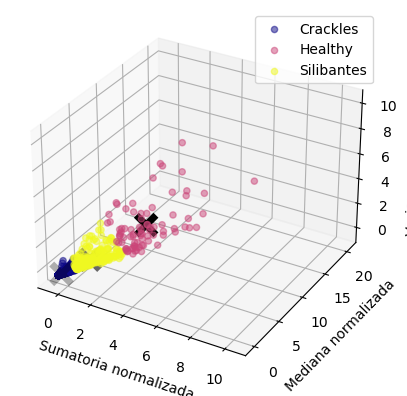

In [212]:
plot_clusters3D(x_kms,y_kms,plotcenter=True)

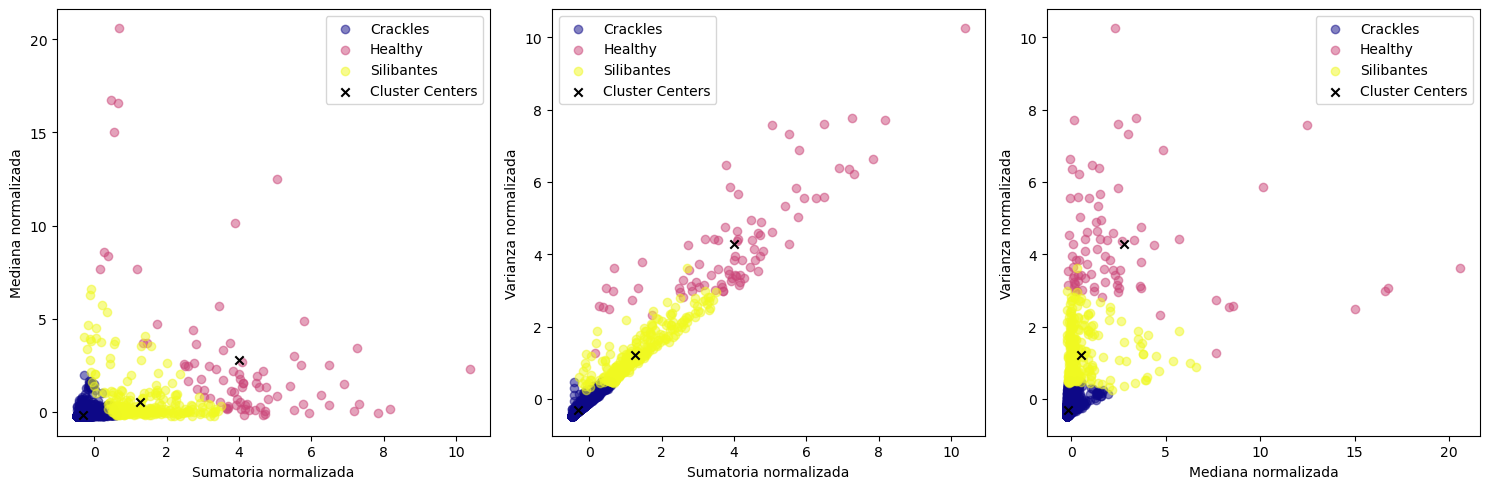

In [213]:
centers_kms = km.cluster_centers_
plot_clusters_2d(x_kms,y_kms,centers_kms,True)

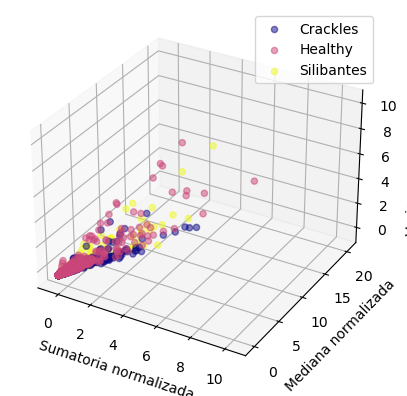

In [214]:
plot_clusters3D(x_kms,y)

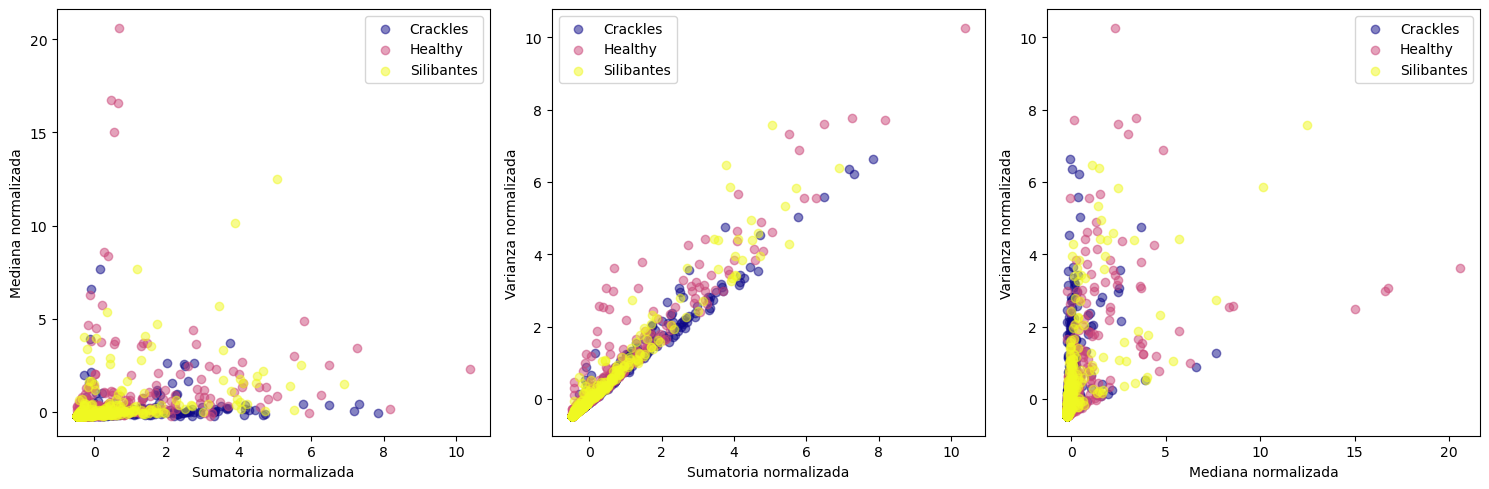

In [215]:
plot_clusters_2d(x_kms,y,centers_kms,False)

In [216]:
km.inertia_

2878.909266406747

In [217]:
silhouette_score(x_kms,km.labels_)

0.7529779668327896

In [218]:
adjusted_rand_score(y,km.labels_)

0.000547592803148906

## 5.2 Kmeans para crepitantes y sanos

En este caso al ser un ejemplo de 3 dimensiones es complicado ver como se hace un cluster o como se ve un centroide, para ello entonces tomaremos un ejemplo dado anteriormente. Así los datos mostrados anteriormente representarían una esfera 3d que encierra los parámetros. En este caso para efectos prácticos eliminaremos la columna de sumatoria la cual presenta menor coherencia con los datos

In [219]:
d=pd.concat([d2[d2["Estado"]==0],d2[d2["Estado"]==1]])
x=d.drop(["Estado","Sumatoria"],axis=1)
y=d.Estado.values
scaler=StandardScaler()
scaler.fit(x)
x_kms=scaler.transform(x)

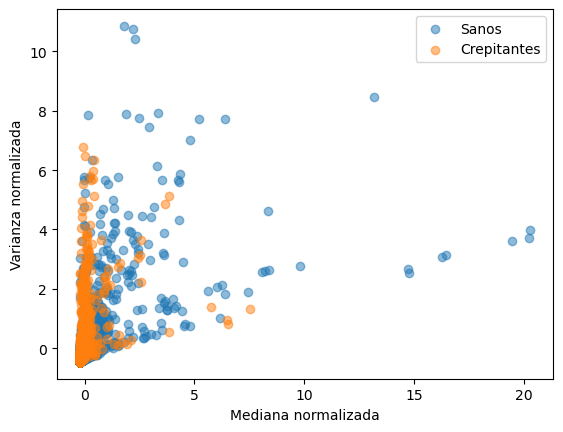

In [220]:
plt.scatter(x_kms[:,0][y==1], x_kms[:,1][y==1],label="Sanos",alpha=.5)
plt.scatter(x_kms[:,0][y==0], x_kms[:,1][y==0],label="Crepitantes",alpha=.5)
plt.xlabel("Mediana normalizada")
plt.ylabel("Varianza normalizada")
plt.legend()

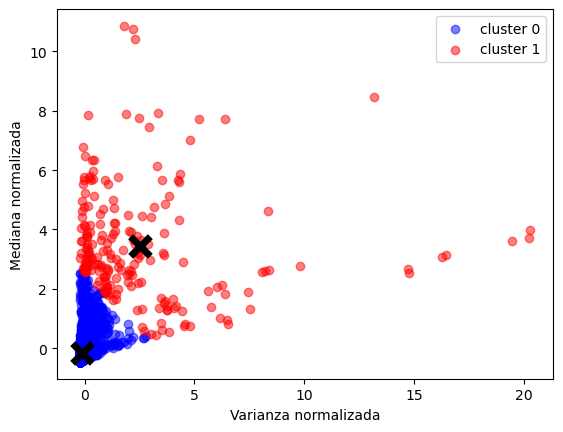

In [221]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters,n_init="auto",random_state=23)
km.fit(x_kms)
y_kms = km.predict(x_kms)
plot_clusters(x_kms,y_kms)

## 6 SVC

## 6.1 Para crackles y healthy

In [222]:
#crackles y sano
d=d2[d2["Estado"]==1].sample(frac=1, random_state=23) #Se aleatoriza para tomar diferentes valores
d=pd.concat([d2[d2["Estado"]==0],d[:int(len(d2[d2["Estado"]==0]))]])
x=d.drop(["Estado"],axis=1)
y=d.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size,stratify=y,random_state=23)
scaler=StandardScaler()
scaler.fit(Xtv)
Xtv=scaler.transform(Xtv)
Xts=scaler.transform(Xts)
print (Xtv.shape, Xts.shape)

(3262, 3) (3262,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2283, 3) (979, 3)


In [223]:
clf = svm.SVC()
kernel=["linear","poly","rbf","sigmoid"]
c=[0.1,0.2,1,2]
param_grid3={"kernel":kernel,"C":c}
grid_search = GridSearchCV(clf, 
                           param_grid3,
                           verbose=2,
                           scoring="neg_log_loss",
                           cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                           n_jobs=-1)
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best=svm.SVC(kernel=best_params["kernel"],C=best_params["C"])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Train SVC
------------


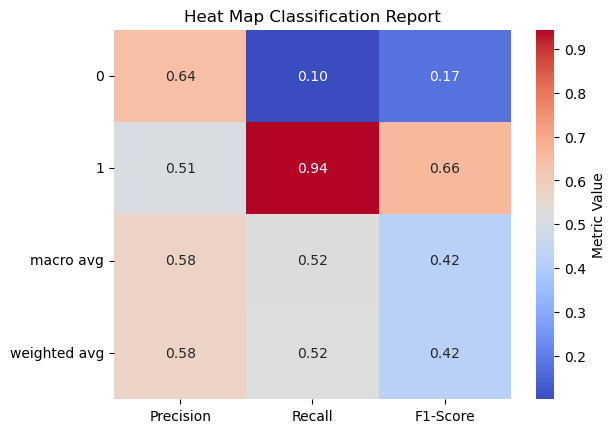

Normalized confusion matrix
------------
Test SVC


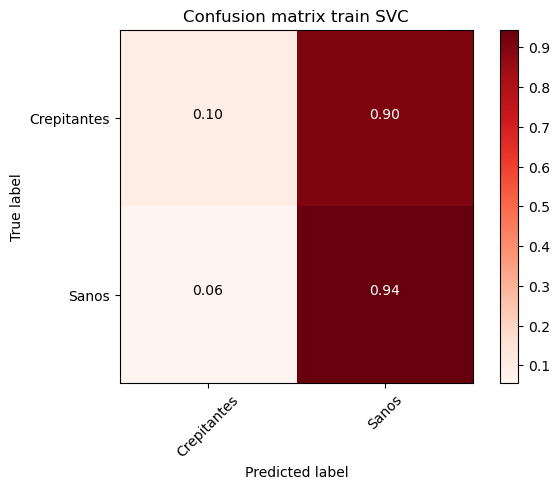

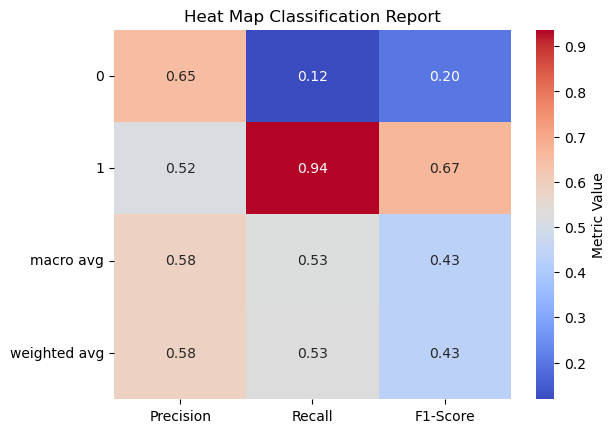

Normalized confusion matrix


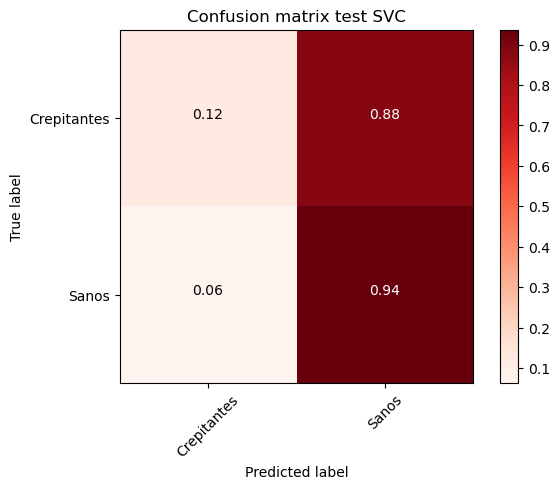

In [224]:
def class_plot(report,class_labels):
        class_labels.remove('accuracy')
        metrics = np.zeros((len(class_labels), 3))
        for idx, label in enumerate(class_labels):
            metrics[idx, 0] = report[label]['precision']
            metrics[idx, 1] = report[label]['recall']
            metrics[idx, 2] = report[label]['f1-score']
        fig, ax = plt.subplots()
        heatmap = sns.heatmap(metrics, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
        ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
        ax.set_yticklabels(class_labels, rotation='horizontal')
        cbar = ax.collections[0].colorbar
        cbar.set_label('Metric Value')
        ax.set_title('Heat Map Classification Report')
        plt.show()
best.fit(Xtv,ytv)
predict_train = best.predict(Xtv)
predict_test = best.predict(Xts)
print("Train SVC")
print("------------")

report = classification_report(ytv,predict_train, output_dict=True)
class_labels = list(report.keys())
class_plot(report,class_labels)

mc_train = confusion_matrix(ytv,predict_train)
plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train SVC',normalize=True)
print("------------")
print("Test SVC")
report = classification_report(yts,predict_test, output_dict=True)
class_labels = list(report.keys())
class_plot(report,class_labels)

mc_train = confusion_matrix(yts,predict_test)
plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test SVC',normalize=True)